These are my solutions to [GPU Puzzles](https://github.com/srush/GPU-Puzzles) created by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp)

<hr>

GPU architectures are critical to machine learning, and seem to be
becoming even more important every day. However, you can be an expert
in machine learning without ever touching GPU code. It is hard to gain
intuition working through abstractions.

This notebook is an attempt to teach beginner GPU programming in a
completely interactive fashion. Instead of providing text with
concepts, it throws you right into coding and building GPU
kernels. The exercises use NUMBA which directly maps Python
code to CUDA kernels. It looks like Python but is basically
identical to writing low-level CUDA code.
In a few hours, I think you can go from basics to
understanding the real algorithms that power 99% of deep learning
today. If you do want to read the manual, it is here:

[NUMBA CUDA Guide](https://numba.readthedocs.io/en/stable/cuda/index.html)

I recommend doing these in Colab, as it is easy to get started.  Be
sure to make your own copy, turn on GPU mode in the settings (`Runtime / Change runtime type`, then set `Hardware accelerator` to `GPU`), and
then get to coding.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/GPU-Puzzles/blob/main/GPU_puzzlers.ipynb)

(If you are into this style of puzzle, also check out my [Tensor
Puzzles](https://github.com/srush/Tensor-Puzzles) for PyTorch.)

In [100]:
!pip install -qqq git+https://github.com/chalk-diagrams/planar git+https://github.com/danoneata/chalk@srush-patch-1
!wget -q https://github.com/srush/GPU-Puzzles/raw/main/robot.png https://github.com/srush/GPU-Puzzles/raw/main/lib.py

In [101]:
import numba
import numpy as np
import warnings
from lib import CudaProblem, Coord

In [102]:
warnings.filterwarnings(
    action="ignore", category=numba.NumbaPerformanceWarning, module="numba"
)

## Puzzle 1: Map

Implement a "kernel" (GPU function) that adds 10 to each position of vector `a`
and stores it in vector `out`.  You have 1 thread per position.

**Warning** This code looks like Python but it is really CUDA! You cannot use
standard python tools like list comprehensions or ask for Numpy properties
like shape or size (if you need the size, it is given as an argument).
The puzzles only require doing simple operations, basically
+, *, simple array indexing, for loops, and if statements.
You are allowed to use local variables.
If you get an
error it is probably because you did something fancy :).

*Tip: Think of the function `call` as being run 1 time for each thread.
The only difference is that `cuda.threadIdx.x` changes each time.*

# Map
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



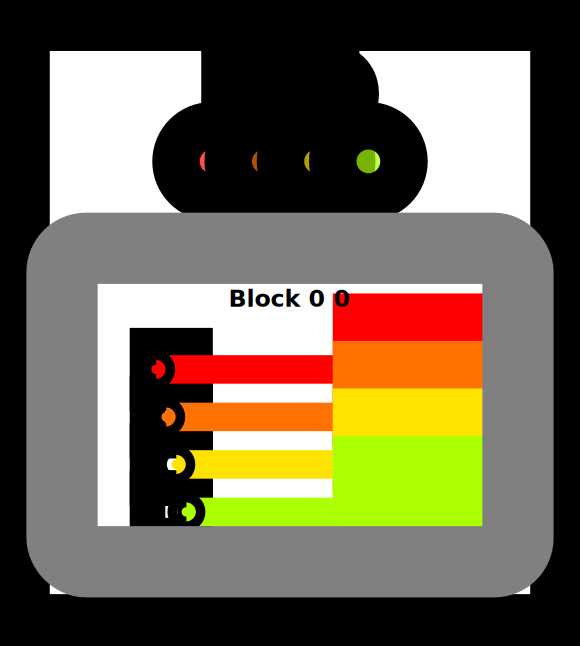

In [103]:
def map_spec(a):
    return a + 10


def map_test(cuda):
    def call(out, a) -> None:
        local_i = cuda.threadIdx.x
        out[local_i] = a[local_i] + 10

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Map", map_test, [a], out, threadsperblock=Coord(SIZE, 1), spec=map_spec
)
problem.show()

In [104]:
# My comment: here and below we use a semicolon to prevent a dog video from
# being rendered. It's a fun addition by the original author, but I foun it too
# distracting for my liking
problem.check();

Passed Tests!


## Puzzle 2 - Zip

Implement a kernel that adds together each position of `a` and `b` and stores it in `out`.
You have 1 thread per position.

# Zip
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 | 



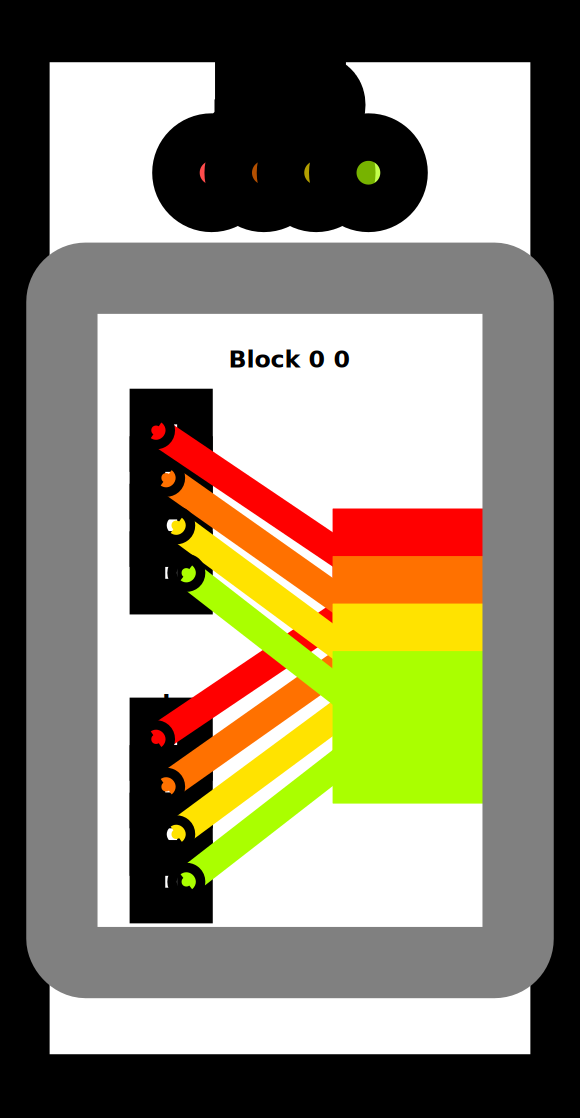

In [105]:
def zip_spec(a, b):
    return a + b


def zip_test(cuda):
    def call(out, a, b) -> None:
        local_i = cuda.threadIdx.x
        out[local_i] = a[local_i] + b[local_i]

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Zip", zip_test, [a, b], out, threadsperblock=Coord(SIZE, 1), spec=zip_spec
)
problem.show()

In [106]:
problem.check();

Passed Tests!


## Puzzle 3 - Guards

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have more threads than positions.

# Guard
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



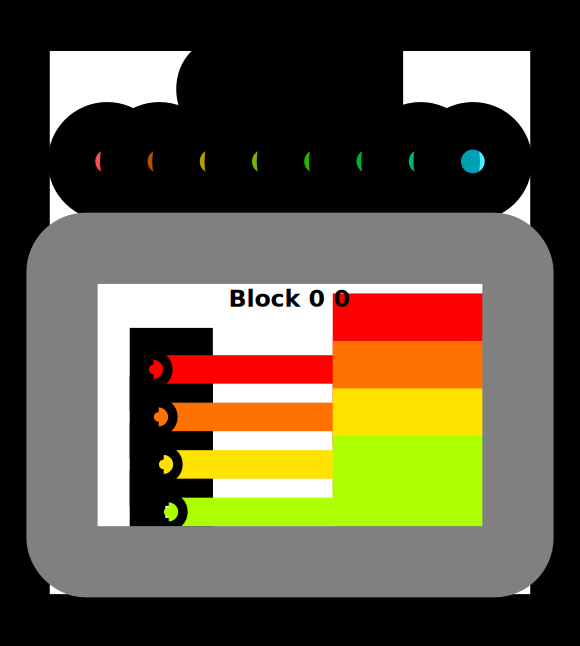

In [107]:
def map_guard_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        if local_i < size:
            out[local_i] = a[local_i] + 10

    return call


# My comment: alternative solution
def map_guard_test_alternative(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        if local_i >= size:
            return

        out[local_i] = a[local_i] + 10

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Guard",
    map_guard_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(8, 1),
    spec=map_spec,
)
problem.show()

In [108]:
problem.check();

Passed Tests!


## Puzzle 4 - Map 2D

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
Input `a` is 2D and square. You have more threads than positions.

# Map 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



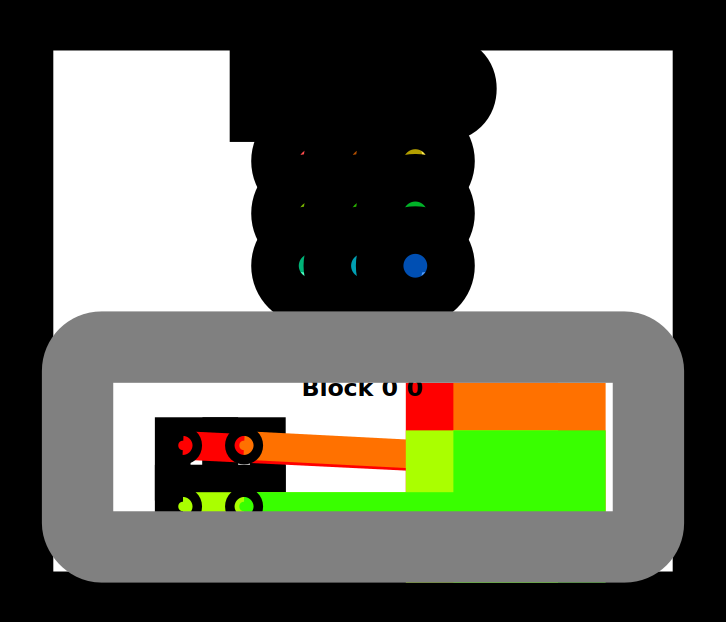

In [109]:
def map_2D_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        if local_i < size and local_j < size:
            out[local_i, local_j] = a[local_i, local_j] + 10

    return call


# My comment: alternative solution is to exit early, requires less indentation
def map_2D_test_alternative(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        
        if local_i >= size or local_j >= size:
            return

        out[local_i, local_j] = a[local_i, local_j] + 10

    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
problem = CudaProblem(
    "Map 2D",
    map_2D_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    spec=map_spec,
)
problem.show()

In [110]:
problem.check();

Passed Tests!


## Puzzle 5 - Broadcast

Implement a kernel that adds `a` and `b` and stores it in `out`.
Inputs `a` and `b` are vectors. You have more threads than positions.

# Broadcast
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 | 



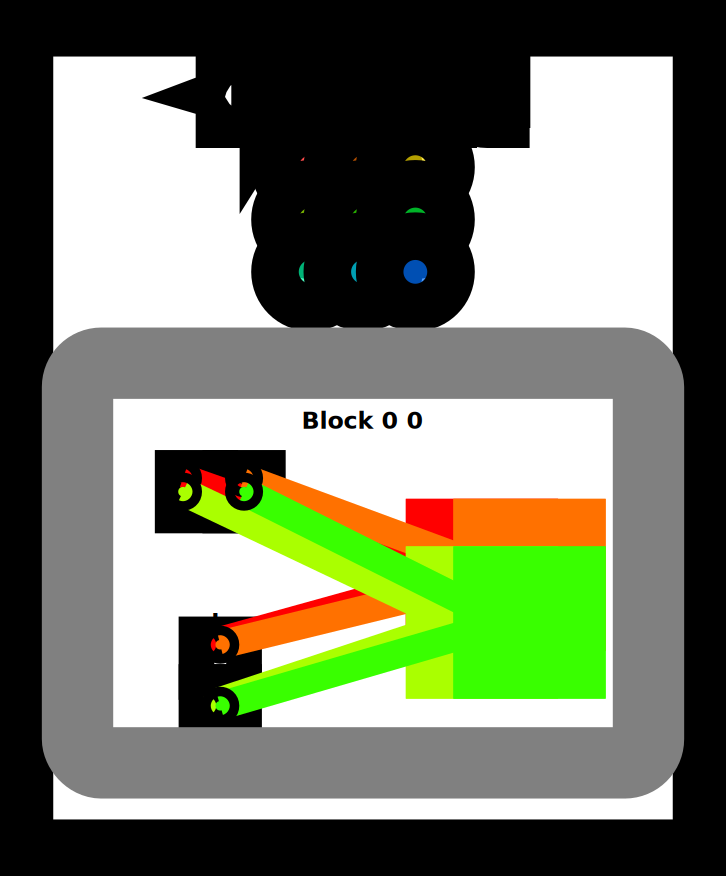

In [111]:
def broadcast_test(cuda):
    def call(out, a, b, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        if local_i < size and local_j < size:
            out[local_i, local_j] = a[local_i, 0] + b[0, local_j]

    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE).reshape(SIZE, 1)
b = np.arange(SIZE).reshape(1, SIZE)
problem = CudaProblem(
    "Broadcast",
    broadcast_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    spec=zip_spec,
)
problem.show()

In [112]:
problem.check();

Passed Tests!


## Puzzle 6 - Blocks

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have fewer threads per block than the size of `a`.

*Tip: A block is a group of threads. The number of threads per block is limited, but we can
have many different blocks. Variable `cuda.blockIdx` tells us what block we are in.*

# Blocks
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



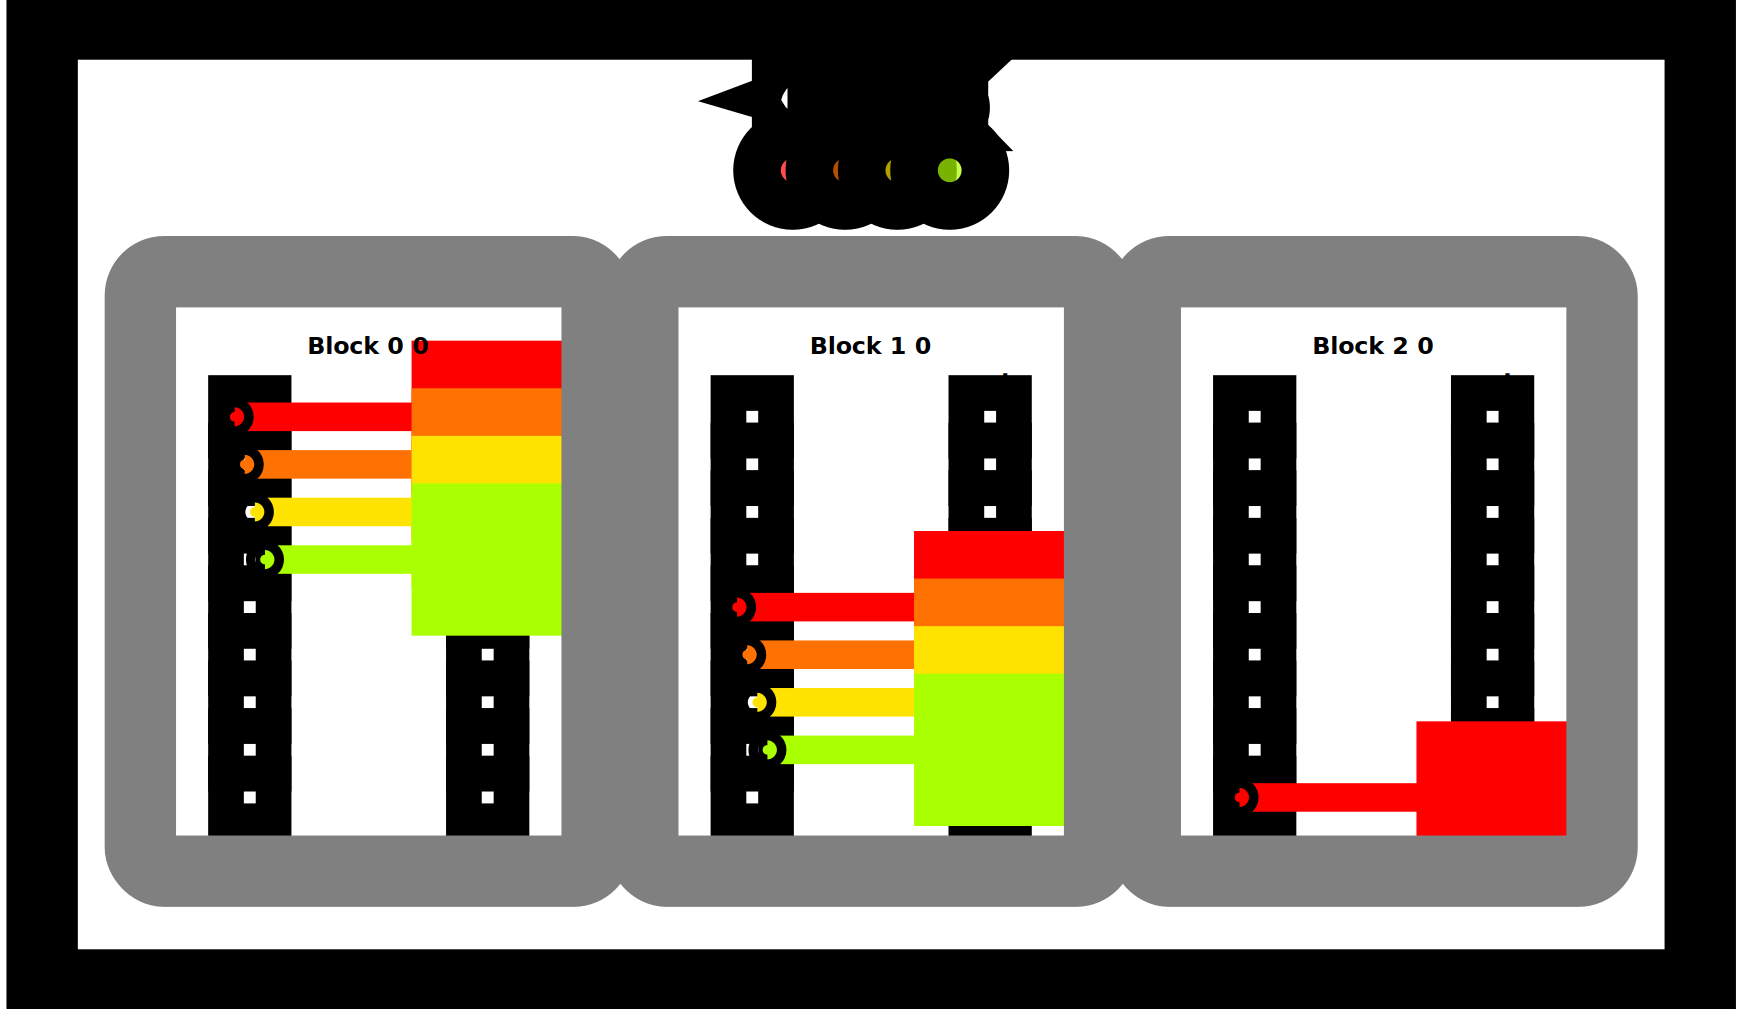

In [113]:
def map_block_test(cuda):
    def call(out, a, size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        
        if i < size:
            out[i] = a[i] + 10

    return call


SIZE = 9
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Blocks",
    map_block_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(4, 1),
    blockspergrid=Coord(3, 1),
    spec=map_spec,
)
problem.show()

In [114]:
problem.check();

Passed Tests!


## Puzzle 7 - Blocks 2D

Implement the same kernel in 2D.  You have fewer threads per block
than the size of `a` in both directions.

# Blocks 2D
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 | 



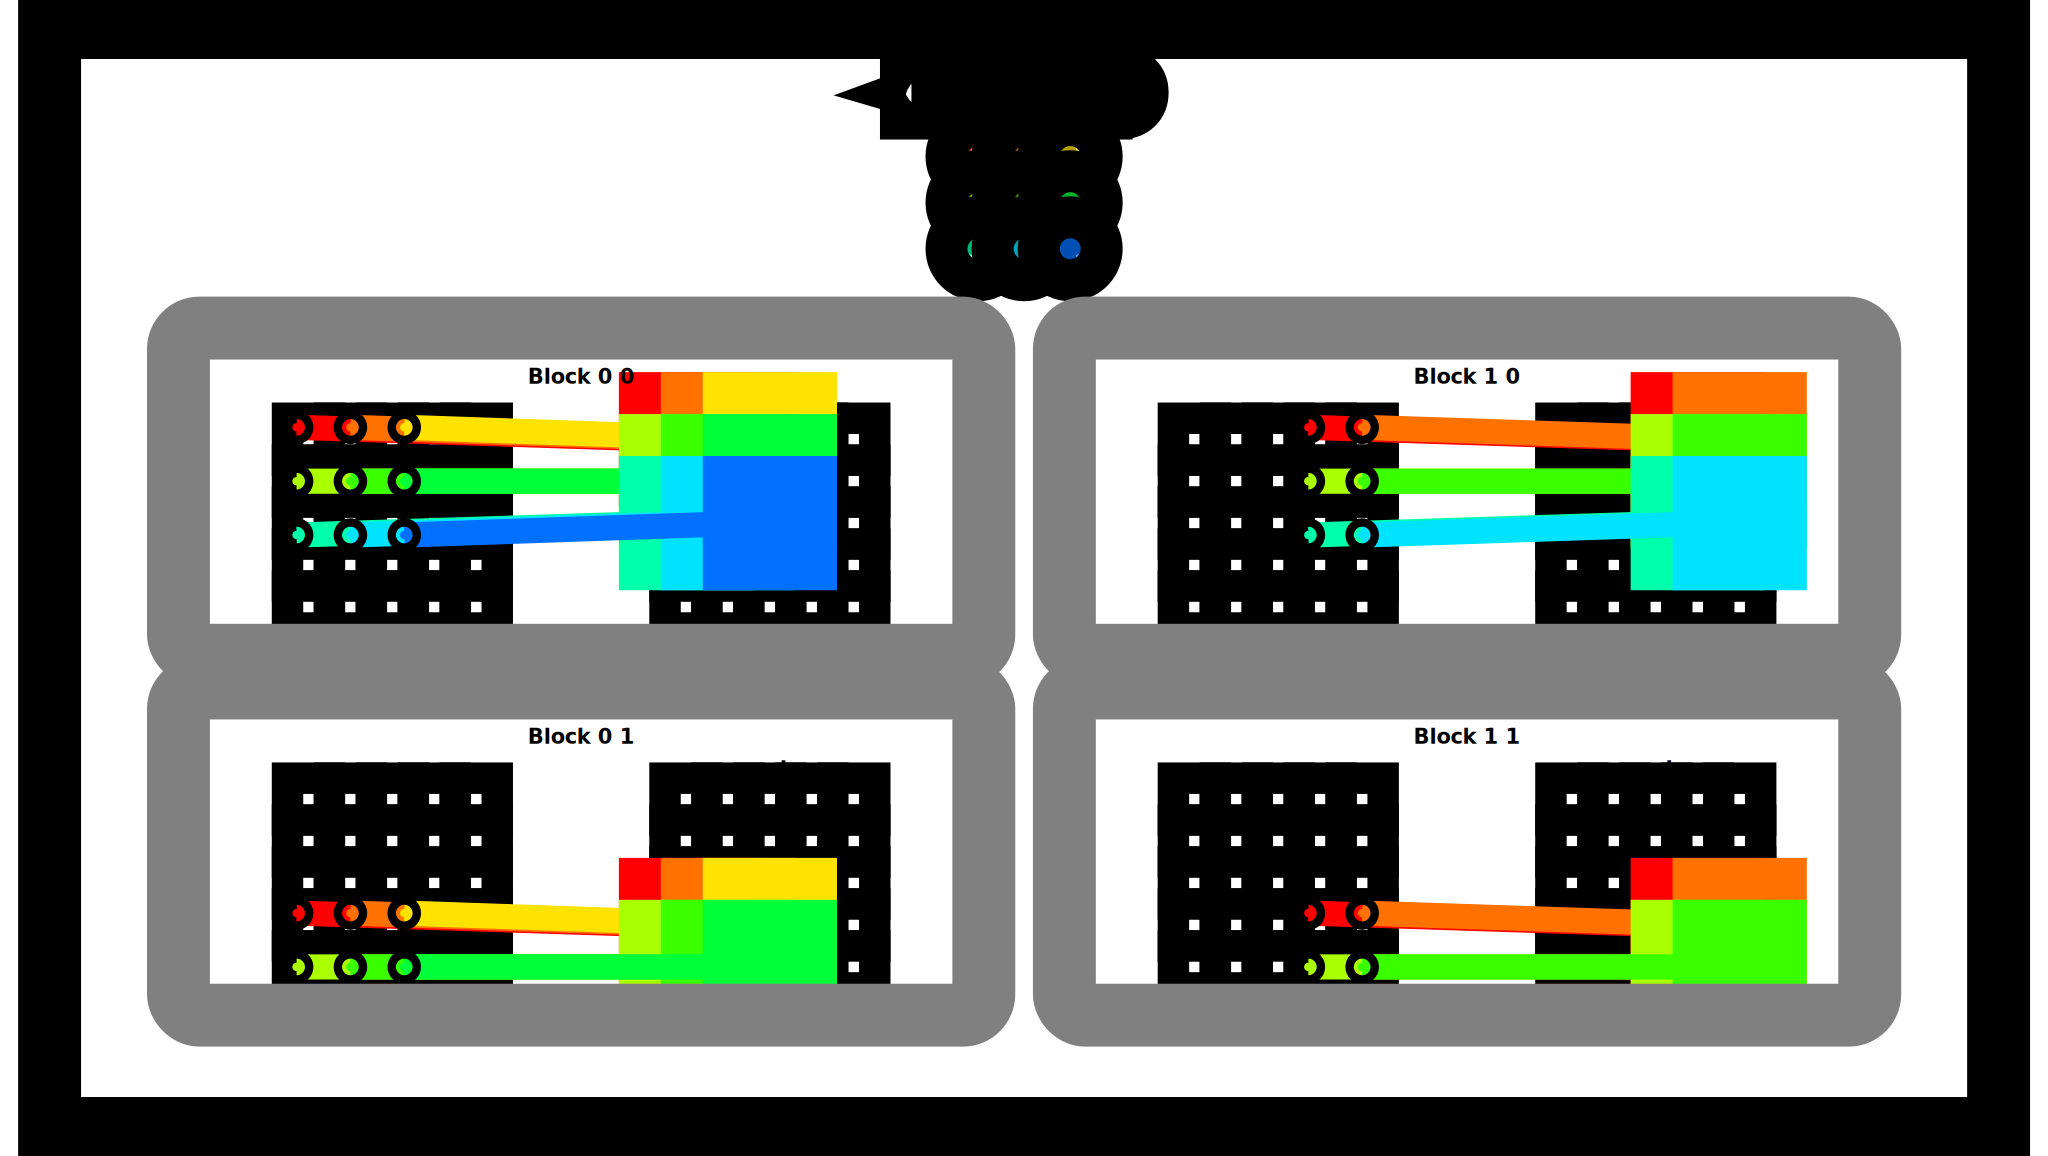

In [115]:
def map_block2D_test(cuda):
    def call(out, a, size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        
        if i < size and j < size:
            out[i, j] = a[i, j] + 10

    return call


SIZE = 5
out = np.zeros((SIZE, SIZE))
a = np.ones((SIZE, SIZE))

problem = CudaProblem(
    "Blocks 2D",
    map_block2D_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    blockspergrid=Coord(2, 2),
    spec=map_spec,
)
problem.show()

In [116]:
problem.check();

Passed Tests!


## Puzzle 8 - Shared

Implement a kernel that adds 10 to each position of `a` and stores it in `out`.
You have fewer threads per block than the size of `a`.

**Warning**: Each block can only have a *constant* amount of shared
 memory that threads in that block can read and write to. This needs
 to be a literal python constant not a variable. After writing to
 shared memory you need to call `cuda.syncthreads` to ensure that
 threads do not cross.

(This example does not really need shared memory or syncthreads, but it is a demo.)

# Shared
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             1 |             1 | 



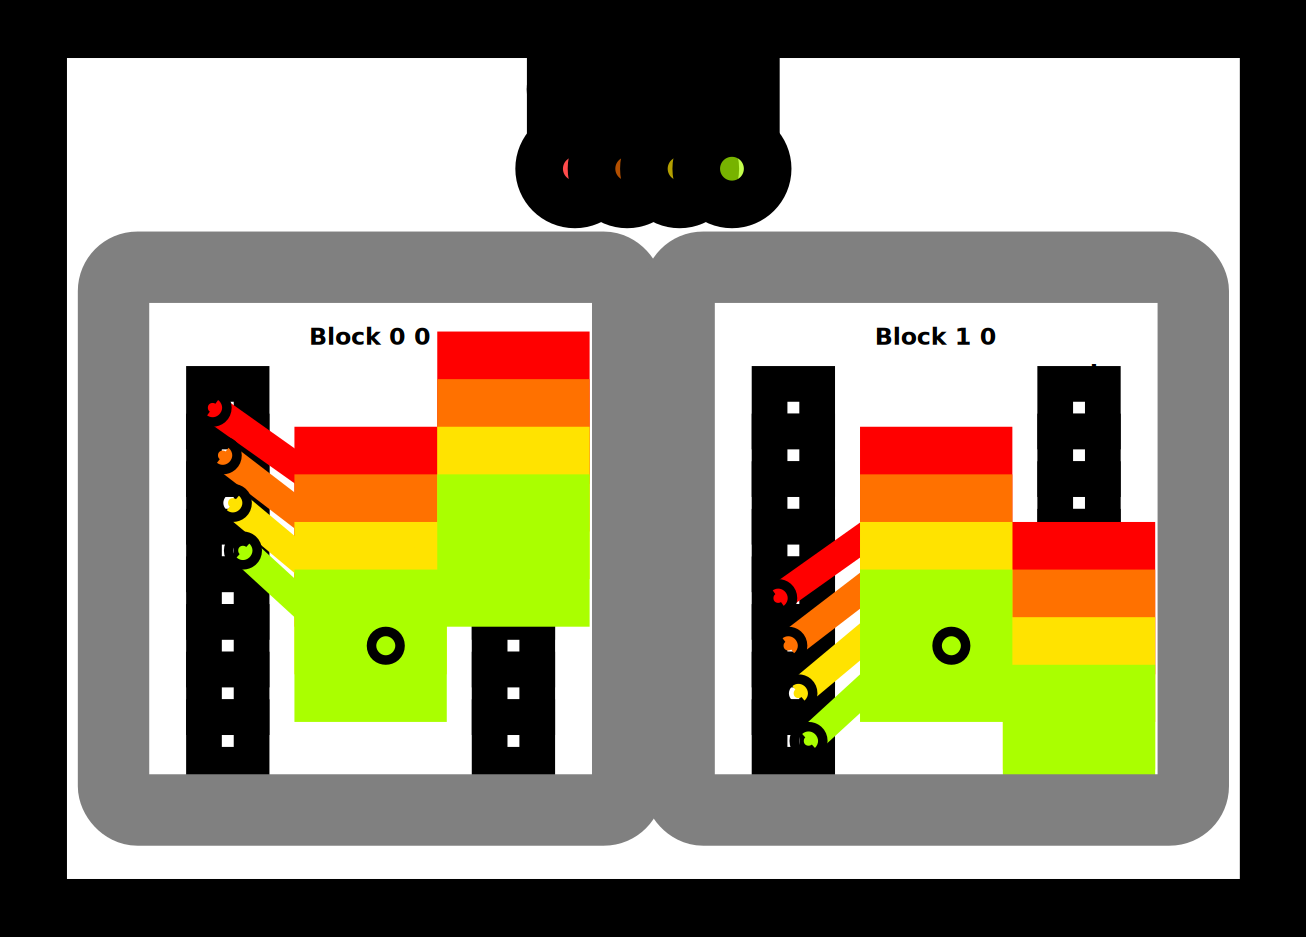

In [117]:
TPB = 4
def shared_test(cuda):
    def call(out, a, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        if i < size:
            shared[local_i] = a[i]
            cuda.syncthreads()
            out[i] = shared[local_i] + 10

    return call


SIZE = 8
out = np.zeros(SIZE)
a = np.ones(SIZE)
problem = CudaProblem(
    "Shared",
    shared_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(TPB, 1),
    blockspergrid=Coord(2, 1),
    spec=map_spec,
)
problem.show()

In [118]:
problem.check();

Passed Tests!


## Puzzle 9 - Pooling

Implement a kernel that sums together the last 3 position of `a` and stores it in `out`.
You have 1 thread per position. You only need 1 global read and 1 global write per thread.

*Tip: Remember to be careful about syncing.*

# Pooling
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             3 |             1 | 



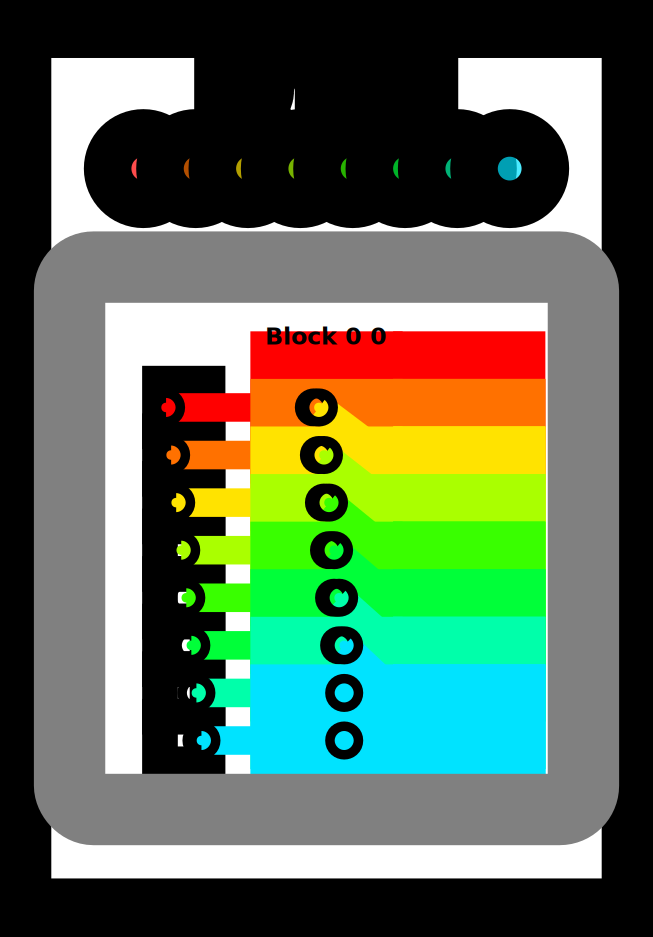

In [119]:
def pool_spec(a):
    out = np.zeros(*a.shape)
    for i in range(a.shape[0]):
        out[i] = a[max(i - 2, 0) : i + 1].sum()
    return out


TPB = 8
def pool_test(cuda):
    def call(out, a, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        # My comment: pull into shared memory
        if i < size:
            shared[local_i] = a[i]
            cuda.syncthreads()

        # My comment: we need to be careful around boundary, but otherwise we
        # just read from shared memory and sum. Note that this is not very
        # general since the pooling size is fixed and we also do not bother with
        # handling inputs that do not fit into one block
        if i == 0:
            out[i] = shared[local_i]
        elif i == 1:
            out[i] = shared[local_i] + shared[local_i - 1]
        else:
            out[i] = shared[local_i] + shared[local_i - 1] + shared[local_i - 2]

    return call


SIZE = 8
out = np.zeros(SIZE)
a = np.arange(SIZE)
problem = CudaProblem(
    "Pooling",
    pool_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(TPB, 1),
    blockspergrid=Coord(1, 1),
    spec=pool_spec,
)
problem.show()

In [120]:
problem.check();

Passed Tests!


## Puzzle 10 - Dot Product

Implement a kernel that computes the dot-product of `a` and `b` and stores it in `out`.
You have 1 thread per position. You only need 2 global reads and 1 global write per thread.

*Note: For this problem you don't need to worry about number of shared reads. We will
 handle that challenge later.*

# Dot
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             8 |             1 | 



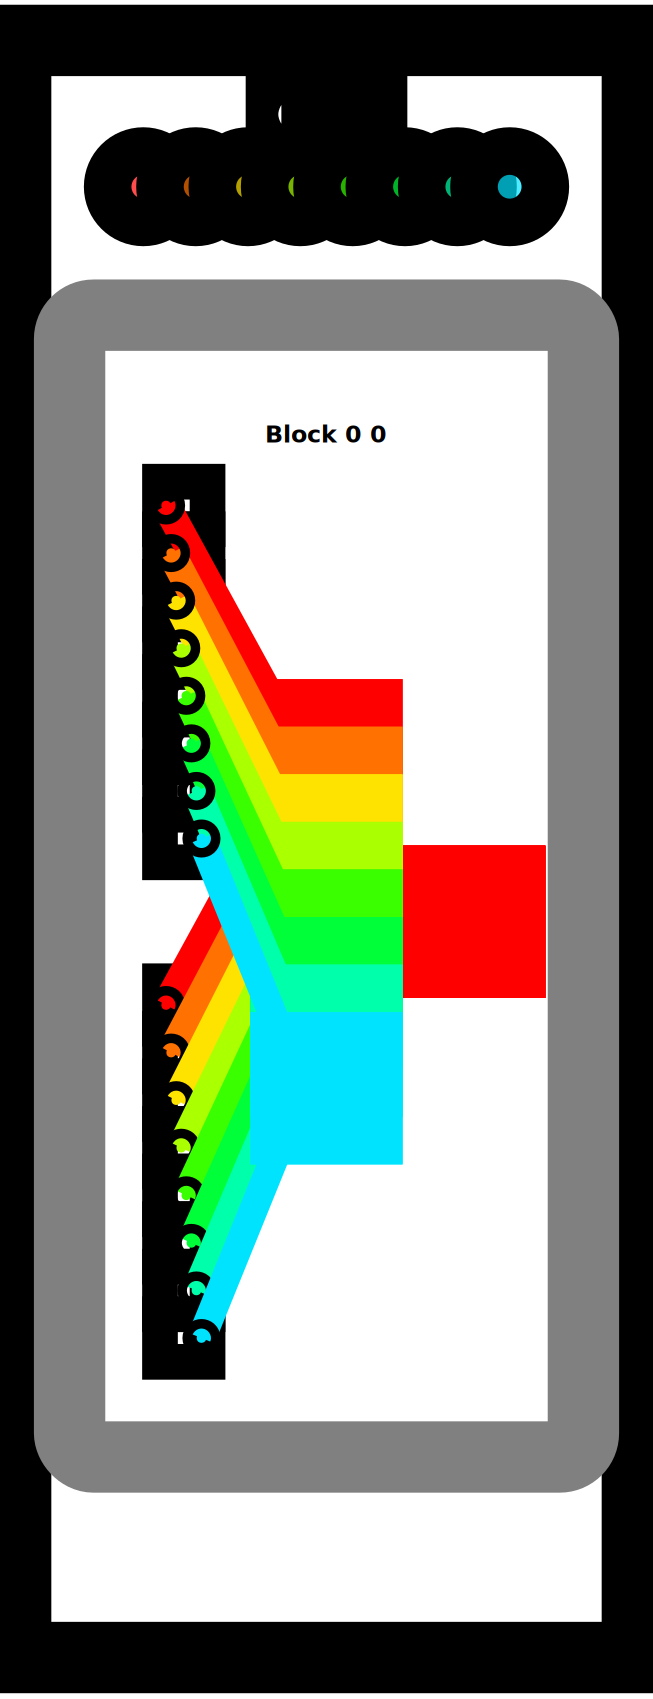

In [121]:
def dot_spec(a, b):
    return a @ b

TPB = 8
def dot_test(cuda):
    def call(out, a, b, size) -> None:
        shared = cuda.shared.array(TPB, numba.float32)

        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 9 lines)

        if i < size:
            shared[local_i] = a[i] * b[i]
            cuda.syncthreads()

        # Only the 0th thread will do the summing
        if local_i > 0: return

        acc = 0
        for k in range(size):
            acc += shared[k]

        out[0] = acc

    return call


SIZE = 8
out = np.zeros(1)
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Dot",
    dot_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(SIZE, 1),
    blockspergrid=Coord(1, 1),
    spec=dot_spec,
)
problem.show()

In [122]:
problem.check();

Passed Tests!


## Puzzle 11 - 1D Convolution

Implement a kernel that computes a 1D convolution between `a` and `b` and stores it in `out`.
You need to handle the general case. You only need 2 global reads and 1 global write per thread.

Passed Tests!
# 1D Conv (Simple)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             6 |             2 | 



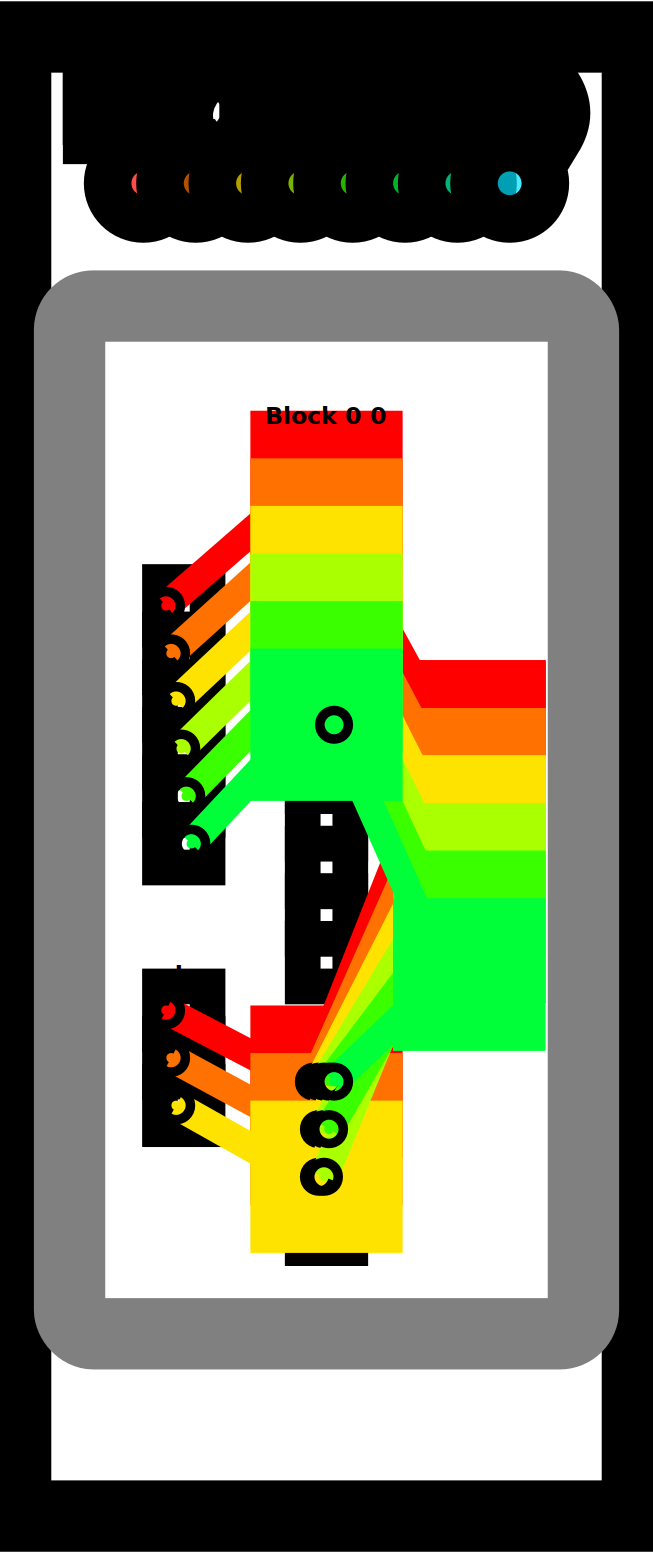

In [123]:
def conv_spec(a, b):
    out = np.zeros(*a.shape)
    len = b.shape[0]
    for i in range(a.shape[0]):
        out[i] = sum(
            [a[i + j] * b[j] for j in range(len) if i + j < a.shape[0]]
        )
    return out


MAX_CONV = 4
TPB = 8
TPB_MAX_CONV = TPB + MAX_CONV
# My comment: we add an additional constant for the size of the memory of
# shared_a. This is because we only need MAX_CONV - 1 extra slots to store the
# boundary values instead of MAX_CONV since one value will come from the last
# position in the block itself
SHARED_A_SIZE = TPB + MAX_CONV - 1
def conv_test(cuda):
    def call(out, a, b, a_size, b_size) -> None:
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        # My comment: create shared memory. Note we allocate memory of size
        # `TPB + MAX_CONV - 1` to store `a` to handle the boundary between
        # blocks correctly (see comment next to where `SHARED_A_SIZE` is defined)
        shared_a = cuda.shared.array(SHARED_A_SIZE, numba.float32)
        shared_b = cuda.shared.array(MAX_CONV, numba.float32)

        # My comment: pull data to shared memory
        if i < a_size:
            shared_a[local_i] = a[i]
        # My comment: the first b_size threads will pull `b` to shared memory
        if local_i < b_size:
            shared_b[local_i] = b[local_i]
        elif local_i < 2 * b_size - 1 and TPB + i - b_size < a_size:
            # My comment: the next `b_size - 1` threads after`b_size` can be
            # used to pull the `b_size - 1` values of `a` that go after the
            # block since we need to them to compute the convolution correcly.
            # This explains the check for `local_i`, and the check for `i`
            # checks that we read the correct part of the memory part and that
            # that part is still withing `a`. It is easier to understand if you
            # consider that `TPB + i` just shifts to the same position in the
            # next block, and then we need to shift back by `b_size` because of
            # which thread is performing the reading and writing.
            # Note that we implicitly asumme and do not check that `TPB` is at
            # least `2 x MAX_CONV - 1` as otherwise we would not have enough
            # threads to read the vector `a` (or at least we'd need to do more
            # than 2 global reads in one of the threads).
            shared_a[TPB + local_i - b_size] = a[TPB + i - b_size]

        # My comment: an alternative solution (and the one proposed by the
        # original author) is the one below. It is essentially the same, but
        # shifting is performed explicitly, and also one too many values is
        # copied. The code should go in an `else` branch instead of the `elif`:
        # -----
        # i2 = i - b_size
        # local_i2 = local_i - b_size
              
        # if local_i2 < b_size - 1 and i2 + TPB < a_size:
        #    shared_a[TPB + local_i2] = a[i2 + TPB]
        # -----

        # My comment: do not forget to sync threads!
        cuda.syncthreads()

        # Compute the actual convolution
        acc = 0
        for j in range(b_size):
            # We only need to check that we do not go over the size of `a` as
            # using `local_i + j` and `j` for the respective reads will be
            # valid by design
            if i + j < a_size:
                acc += shared_a[local_i + j] * shared_b[j]

        if i < a_size:
            out[i] = acc

    return call


# Test 1

SIZE = 6
CONV = 3
out = np.zeros(SIZE)
a = np.arange(SIZE)
b = np.arange(CONV)
problem = CudaProblem(
    "1D Conv (Simple)",
    conv_test,
    [a, b],
    out,
    [SIZE, CONV],
    Coord(1, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.check()
problem.show()

Passed Tests!
# 1D Conv (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             8 |             2 | 



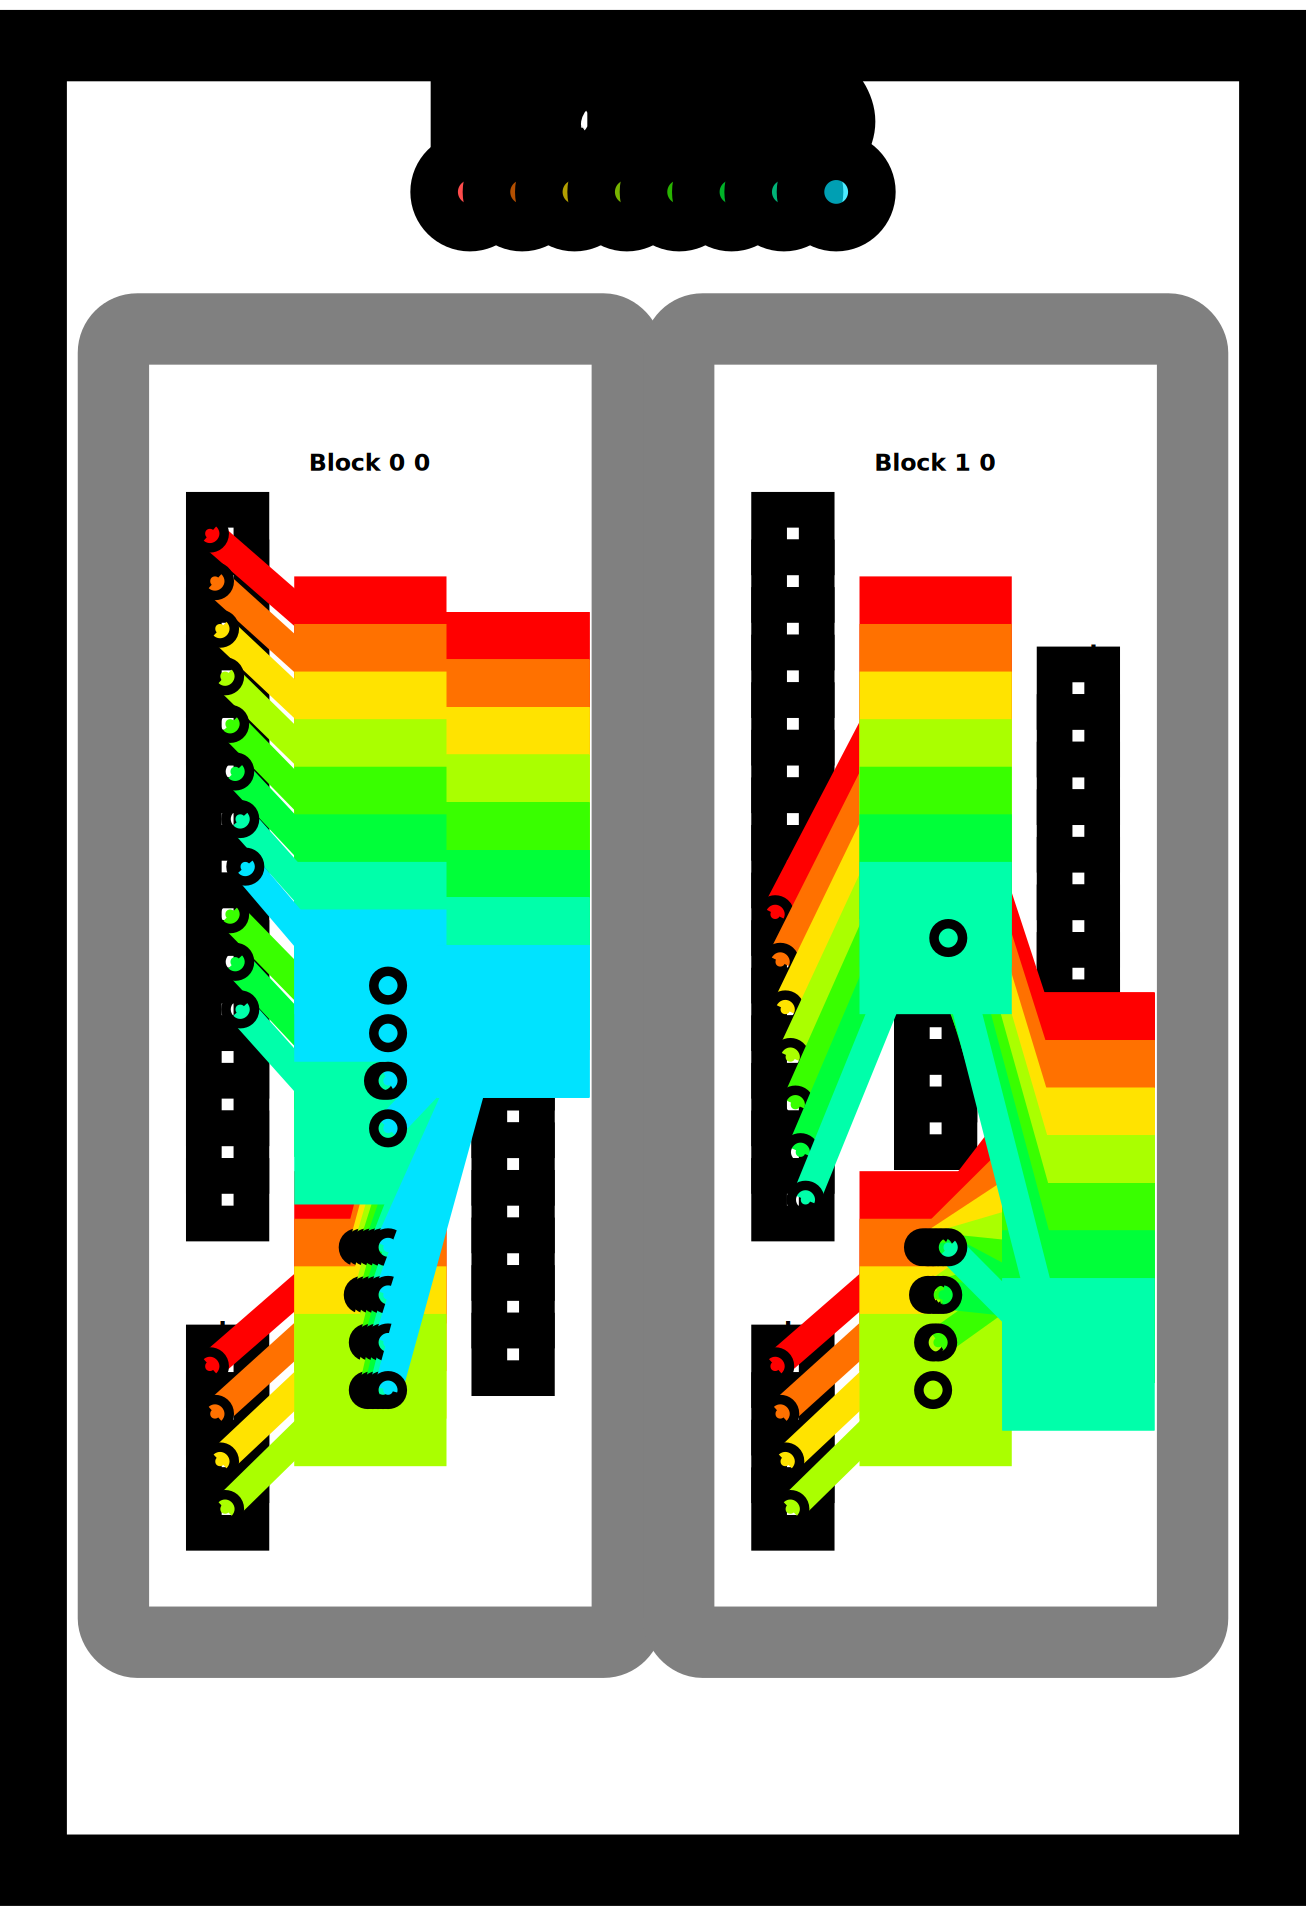

In [124]:
out = np.zeros(15)
a = np.arange(15)
b = np.arange(4)
problem = CudaProblem(
    "1D Conv (Full)",
    conv_test,
    [a, b],
    out,
    [15, 4],
    Coord(2, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.check()
problem.show()

Passed Tests!
# 1D Conv (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             8 |             2 | 



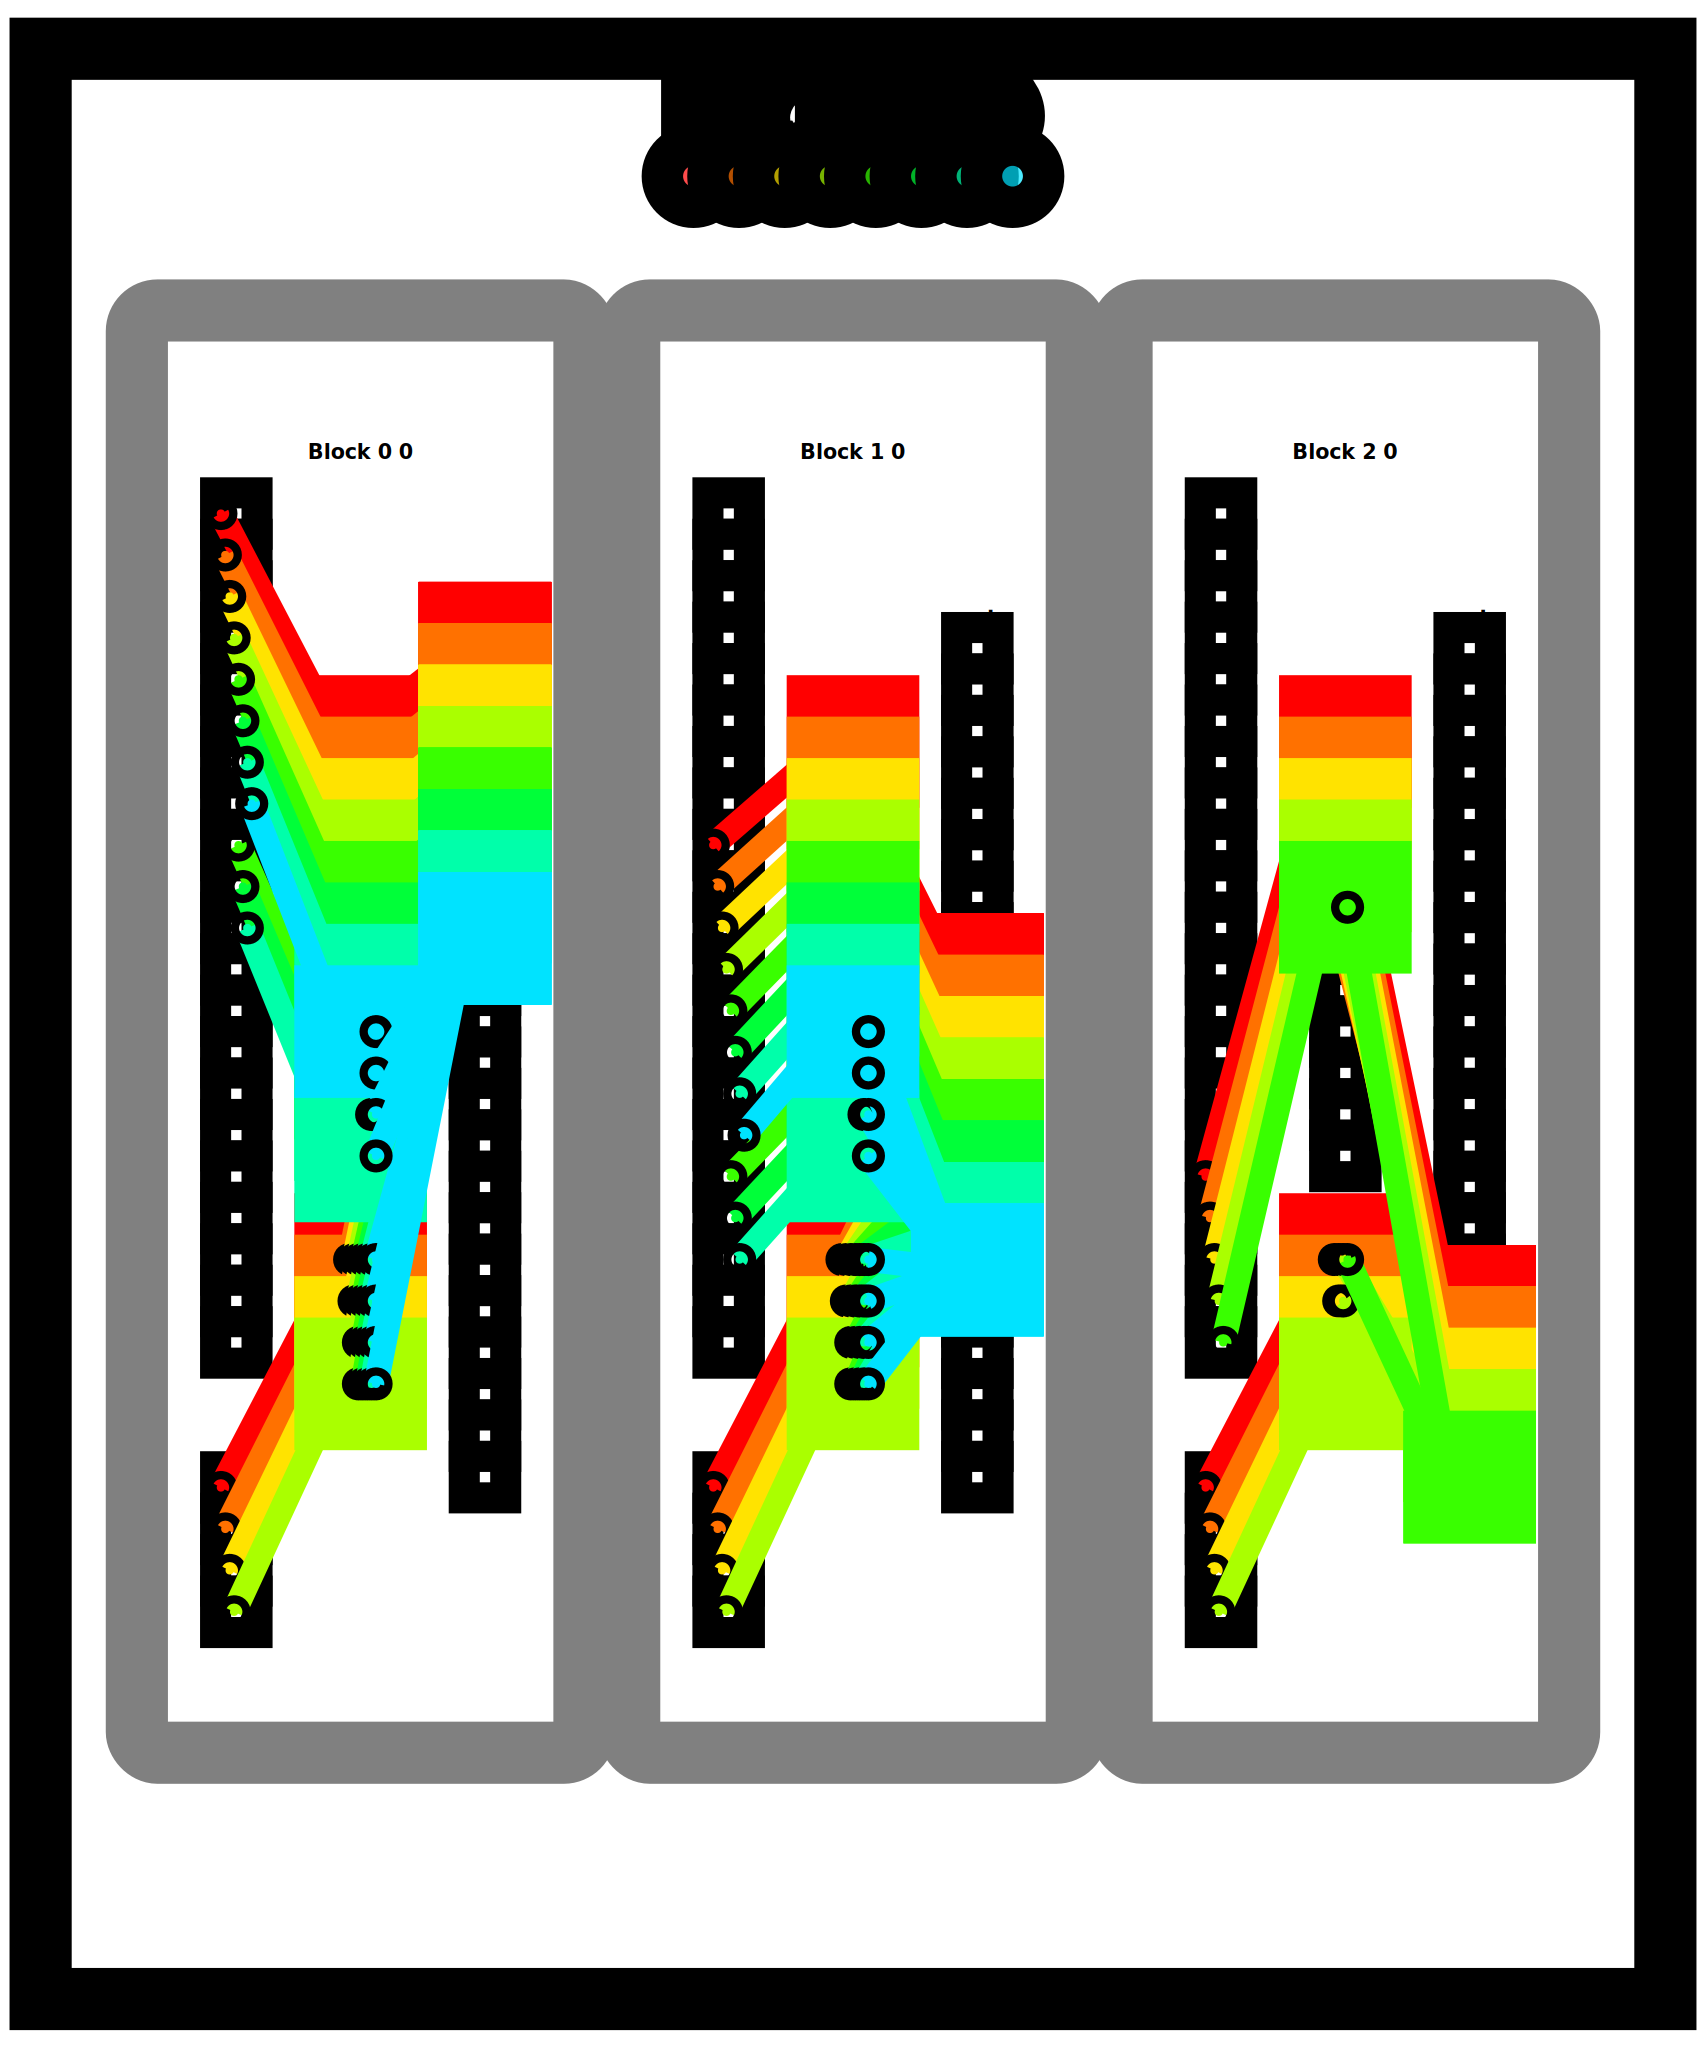

In [125]:
# My comment: let's create an additional text to check that it works for too
out = np.zeros(21)
a = np.arange(21)
b = np.arange(4)
problem = CudaProblem(
    "1D Conv (Full)",
    conv_test,
    [a, b],
    out,
    [21, 4],
    Coord(3, 1),
    Coord(TPB, 1),
    spec=conv_spec,
)
problem.check()
problem.show()

## Puzzle 12 - Prefix Sum

Implement a kernel that computes a sum over `a` and stores it in `out`.
If the size of `a` is greater than the block size, only store the sum of
each block.

We will do this using the [parallel prefix sum](https://en.wikipedia.org/wiki/Prefix_sum) algorithm in shared memory.
That is, each step of the algorithm should sum together half the remaining numbers.
Follow this diagram:

![](https://user-images.githubusercontent.com/35882/178757889-1c269623-93af-4a2e-a7e9-22cd55a42e38.png)

Passed Tests!
# Sum (Simple)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



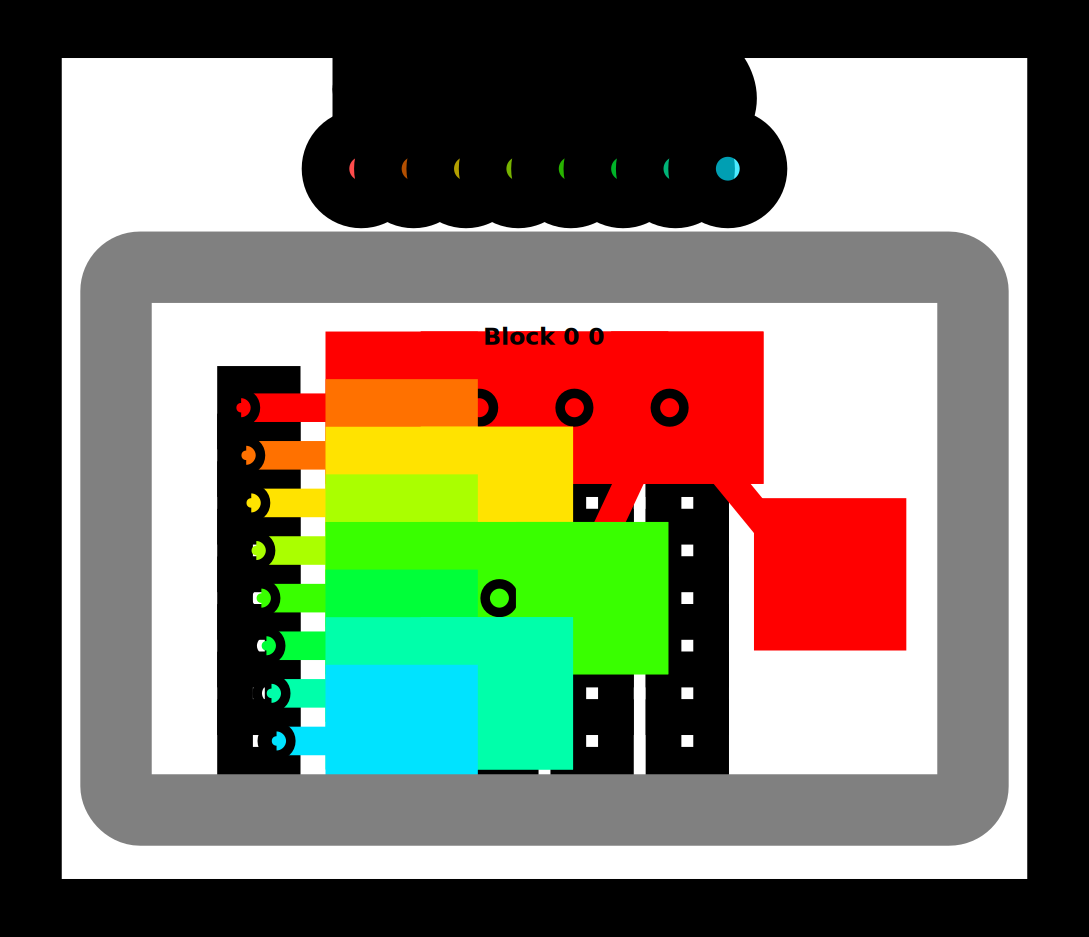

In [126]:
def sum_spec(a):
    out = np.zeros((a.shape[0] + TPB - 1) // TPB)
    for j, i in enumerate(range(0, a.shape[-1], TPB)):
        out[j] = a[i : i + TPB].sum()
    return out


TPB = 8
def sum_test(cuda):
    def call(out, a, size: int) -> None:
        cache = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x

        # My comment: this is the original code
        # -----
        # if i < size:
        #     cache[local_i] = a[i]
        #     cuda.syncthreads()

        #     for p in range(3):
        #         two_to_power_p = 2**p

        #         if (
        #             local_i % (two_to_power_p * 2) == 0
        #             and i + two_to_power_p < size
        #         ):
        #             cache[local_i] = (
        #                 cache[local_i] + cache[local_i + two_to_power_p]
        #             )

        #         # Sync threads at the end of the loop
        #         cuda.syncthreads()

        #     if local_i == 0:
        #         out[cuda.blockIdx.x] = cache[0]
        # -----

        # My comment: this is my code which reduces the amount of
        # indentation and produces a more complete (and therefore
        # more intuitive!) visualisation
        if i >= size:
            return

        cache[local_i] = a[i]
        cuda.syncthreads()

        for p in range(3):
            two_to_power_p = 2**p

            if (
                local_i % (two_to_power_p * 2) == 0
                and i + two_to_power_p < size
            ):
                cache[local_i] = (
                    cache[local_i] + cache[local_i + two_to_power_p]
                )
            elif local_i % (two_to_power_p * 2) == 0:
                # My comment: this else statement is what makes
                # the visualisation nicer
                cache[local_i] = cache[local_i]

            # Sync threads at the end of the loop
            cuda.syncthreads()

        if local_i == 0:
            out[cuda.blockIdx.x] = cache[0]

    return call


# Test 1
SIZE = 8
out = np.zeros((SIZE - 1) // TPB + 1)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Simple)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord((SIZE - 1) // TPB + 1, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.check()
problem.show()

Passed Tests!
# Sum (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



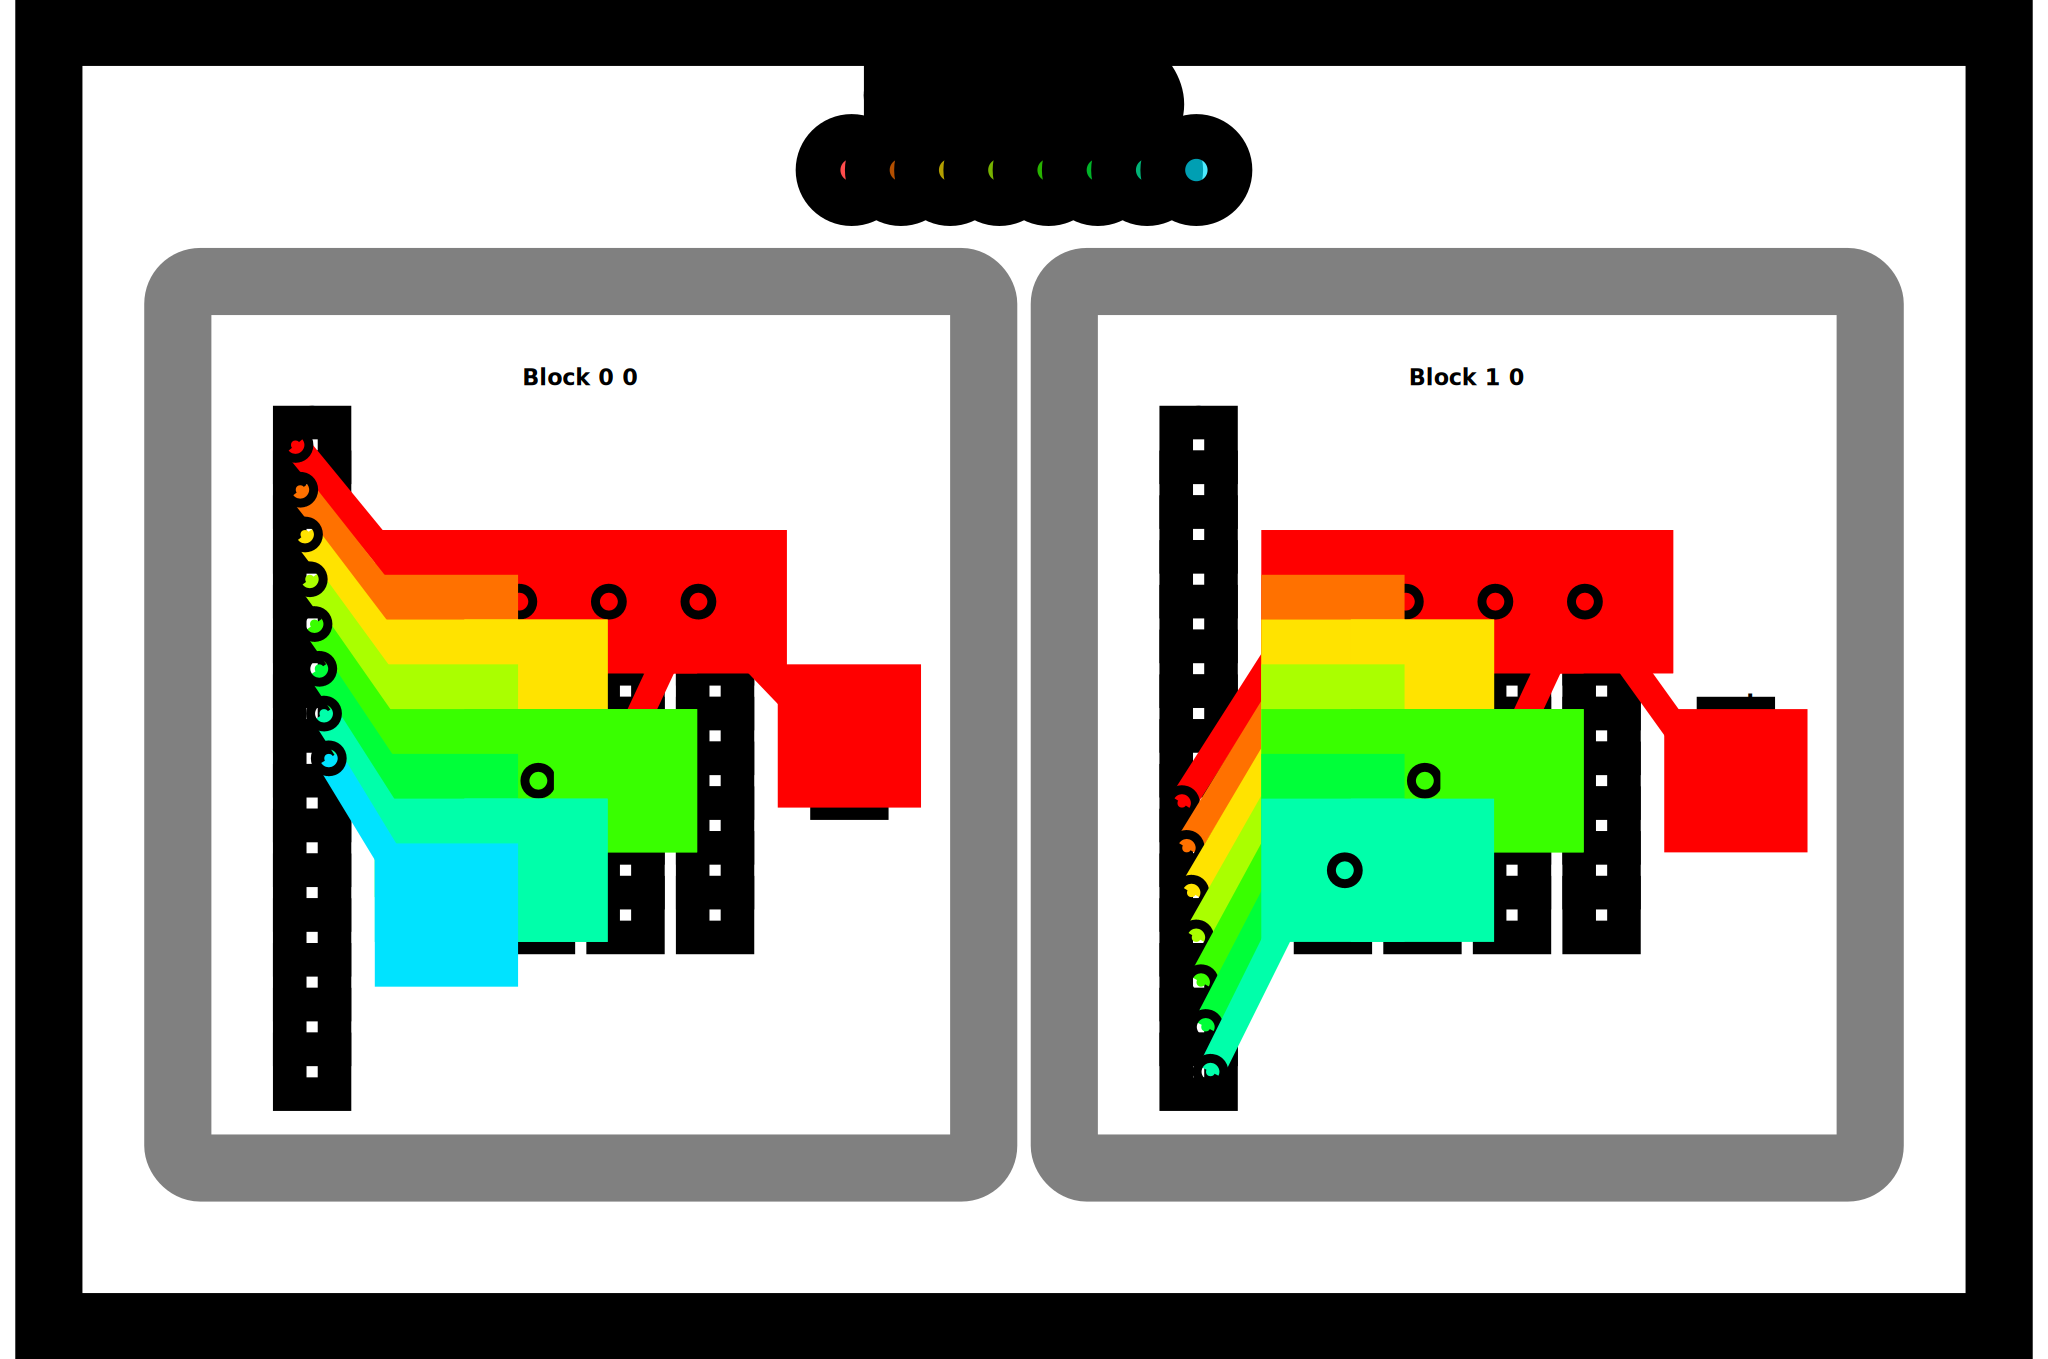

In [127]:
SIZE = 15
out = np.zeros((SIZE - 1) // TPB + 1)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Full)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord((SIZE - 1) // TPB + 1, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.check()
problem.show()

Passed Tests!
# Sum (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



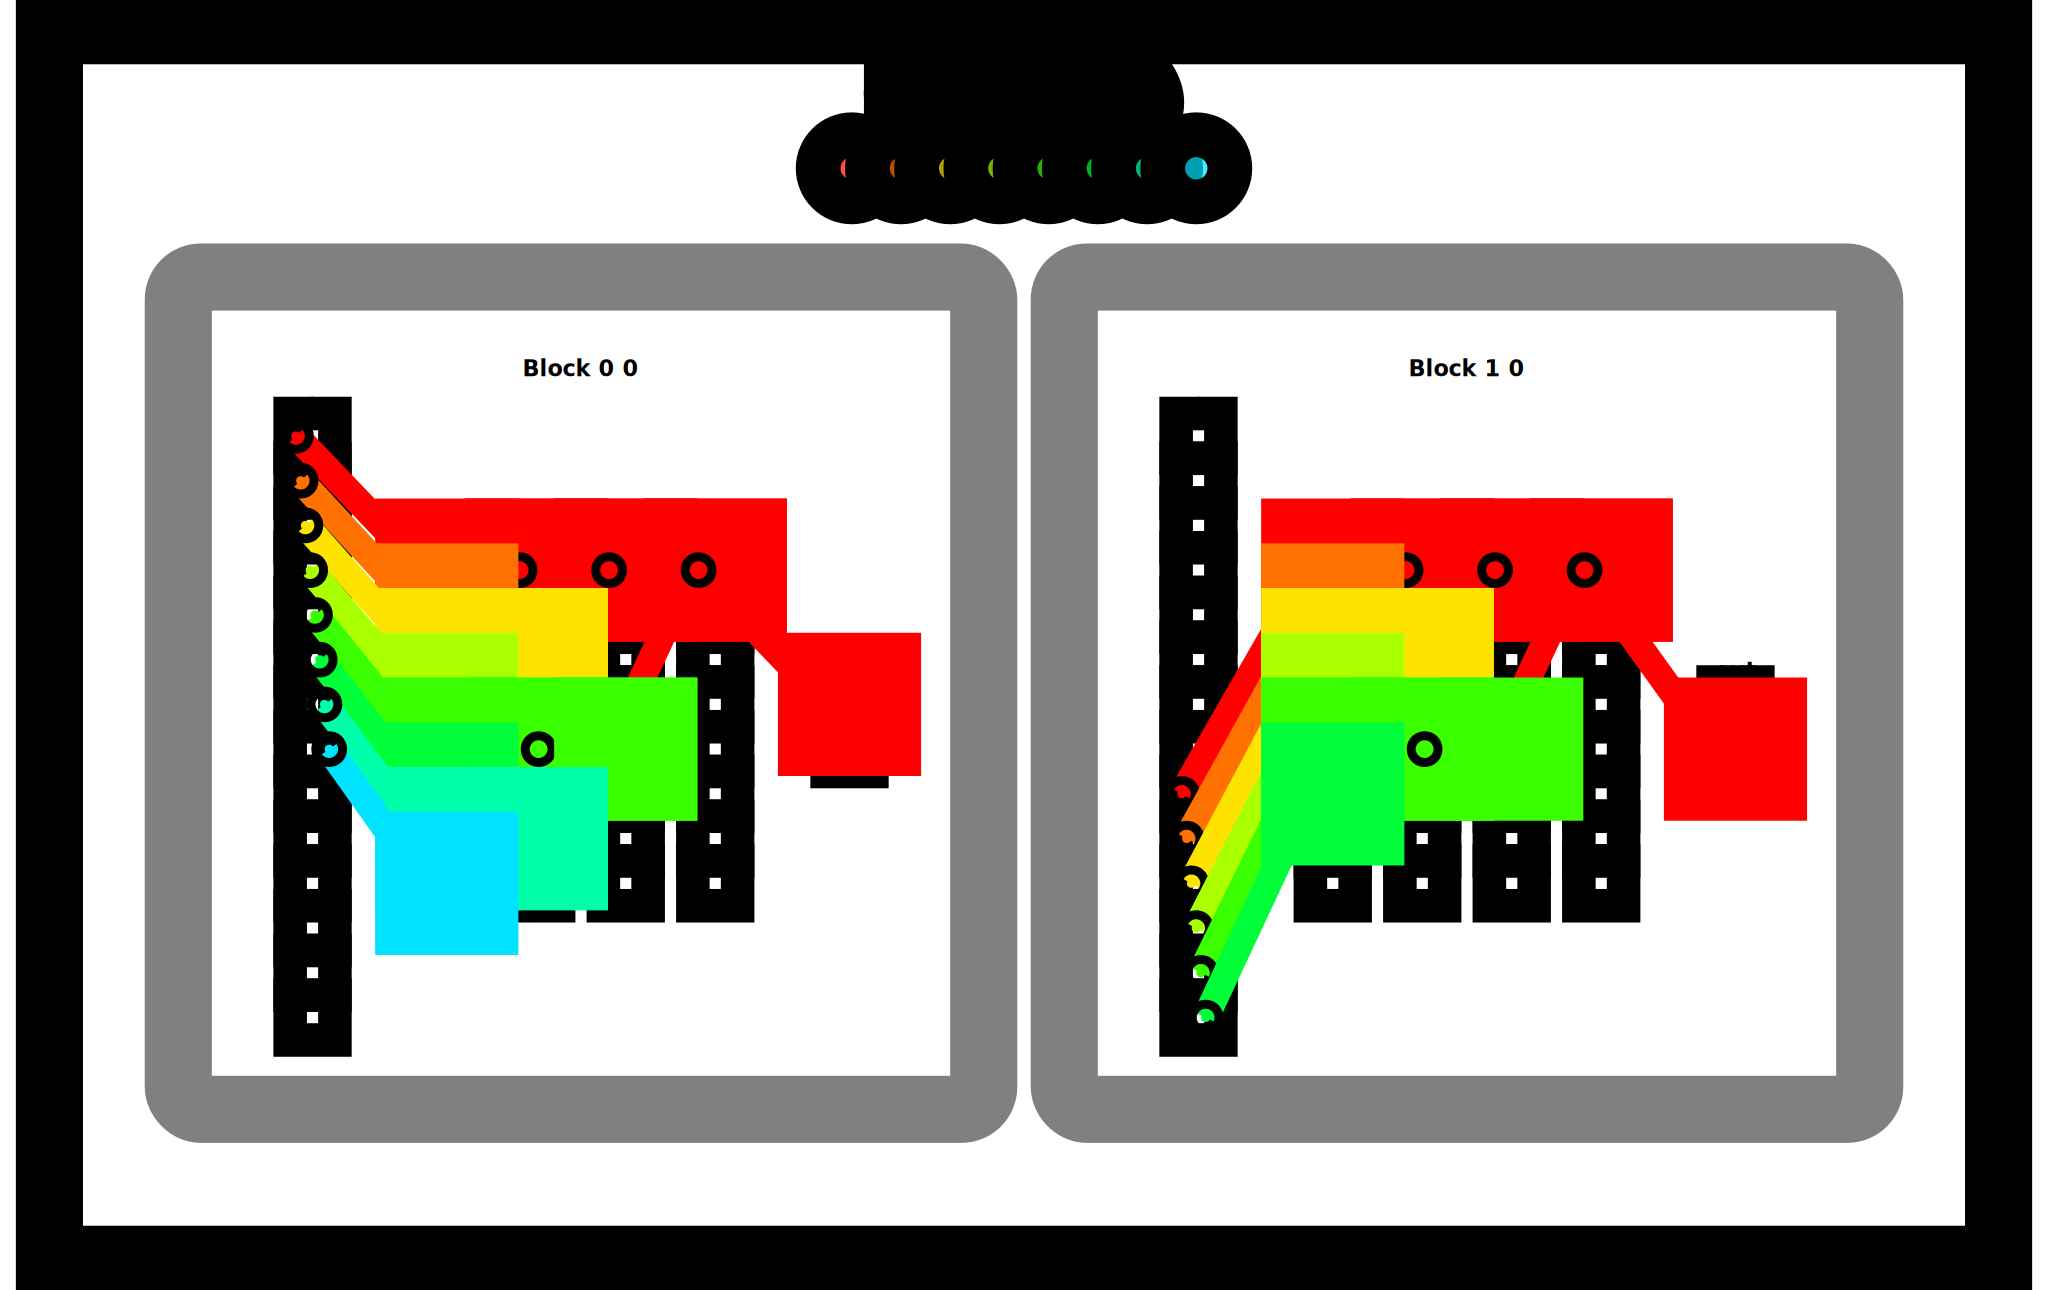

In [128]:
# My comment: additional test to check the visualisation
SIZE = 14
out = np.zeros((SIZE - 1) // TPB + 1)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Full)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord((SIZE - 1) // TPB + 1, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.check()
problem.show()

Passed Tests!
# Sum (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



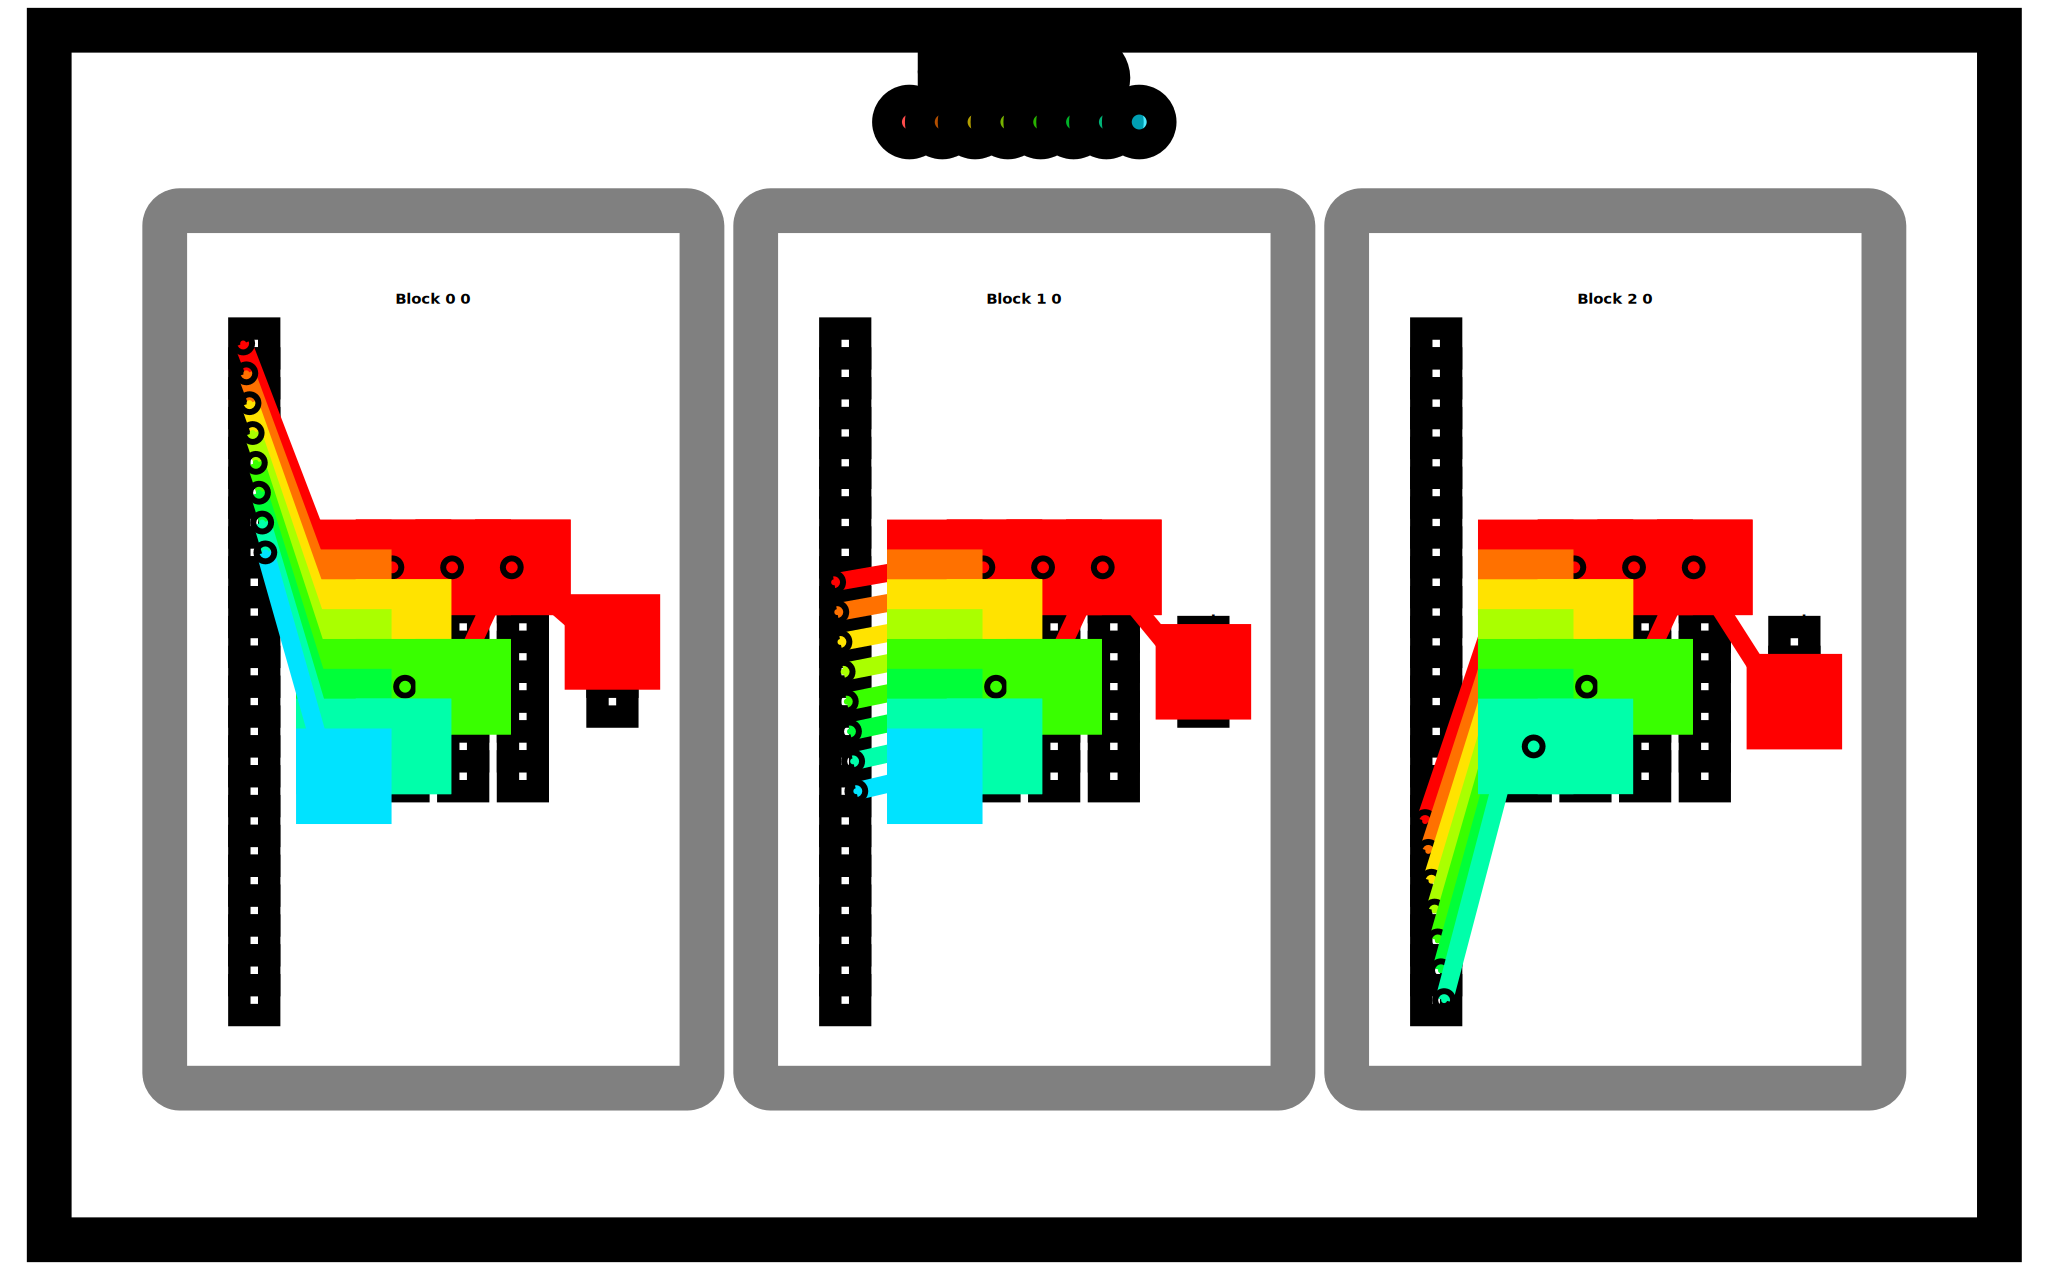

In [129]:
# My comment: additional test to check that the code generalizes to
# 3 blocks or more
SIZE = 23
out = np.zeros((SIZE - 1) // TPB + 1)
inp = np.arange(SIZE)
problem = CudaProblem(
    "Sum (Full)",
    sum_test,
    [inp],
    out,
    [SIZE],
    Coord((SIZE - 1) // TPB + 1, 1),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.check()
problem.show()

## Puzzle 13 - Axis Sum

Implement a kernel that computes a sum over each column of `a` and stores it in `out`.

Passed Tests!
# Axis Sum
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             7 |             4 | 



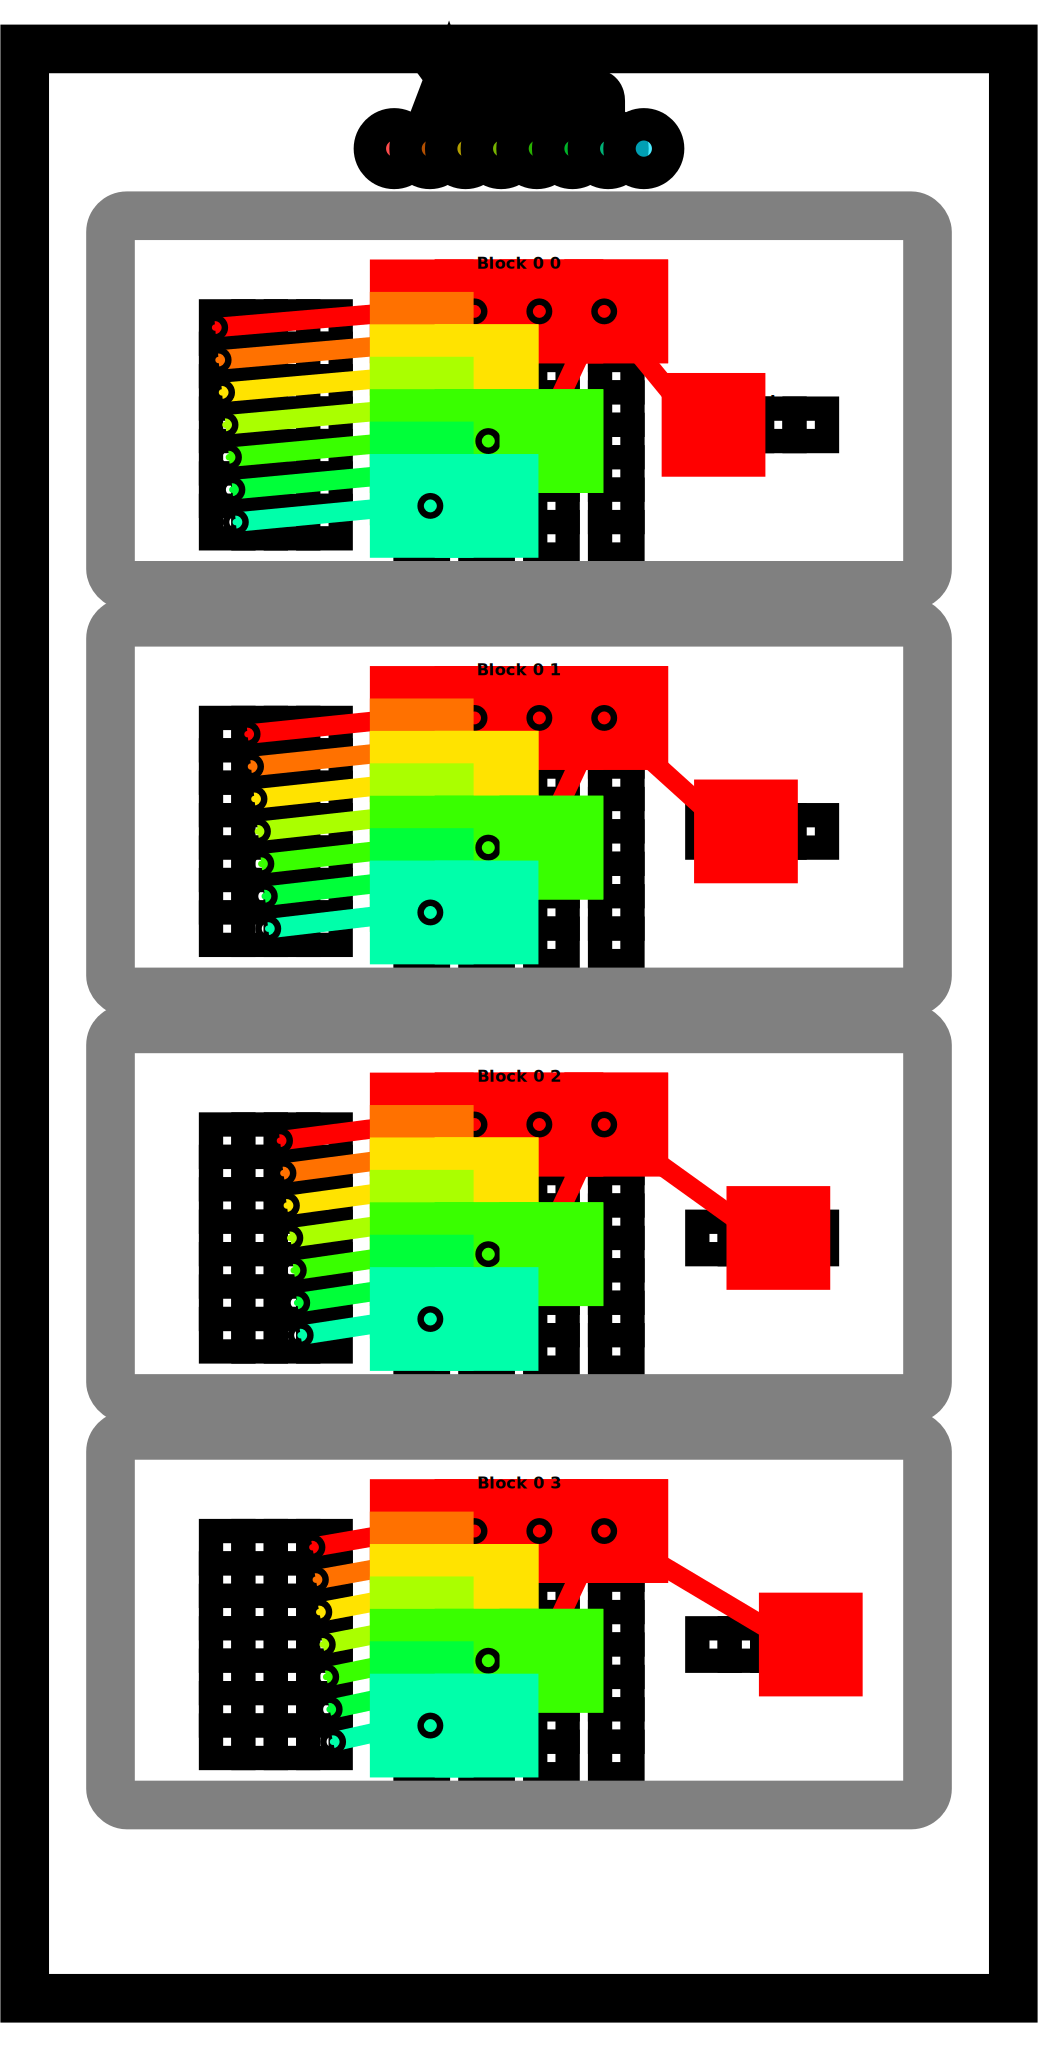

In [130]:
def sum_spec(a):
    out = np.zeros((a.shape[0], (a.shape[1] + TPB - 1) // TPB))
    for j, i in enumerate(range(0, a.shape[-1], TPB)):
        out[..., j] = a[..., i : i + TPB].sum(-1)
    return out


TPB = 8
def axis_sum_test(cuda):
    def call(out, a, size: int) -> None:
        cache = cuda.shared.array(TPB, numba.float32)
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        local_i = cuda.threadIdx.x
        batch = cuda.blockIdx.y

        # My comment: since I came up with my own implementation of prefix sums,
        # this solution is a bit different as well
        if i >= size:
            return

        cache[local_i] = a[batch, i]
        cuda.syncthreads()

        for p in range(3):
            two_to_power_p = 2**p

            if (
                local_i % (two_to_power_p * 2) == 0
                and i + two_to_power_p < size
            ):
                cache[local_i] = (
                    cache[local_i] + cache[local_i + two_to_power_p]
                )
            elif local_i % (two_to_power_p * 2) == 0:
                cache[local_i] = cache[local_i]

            # Sync threads at the end of the loop
            cuda.syncthreads()

        if local_i == 0:
            out[batch, 0] = cache[0]

    return call


BATCH = 4
SIZE = 7
out = np.zeros((BATCH, 1))
inp = np.arange(BATCH * SIZE).reshape((BATCH, SIZE))
problem = CudaProblem(
    "Axis Sum",
    axis_sum_test,
    [inp],
    out,
    [SIZE],
    Coord(1, BATCH),
    Coord(TPB, 1),
    spec=sum_spec,
)
problem.check()
problem.show()

## Puzzle 14 - Matrix Multiply!

Implement a kernel that multiplies square matrices `a` and `b` and
stores the result in `out`.

*Tip: The most efficient algorithm here will copy a block into
 shared memory before computing each of the individual row-column
 dot products. This is easy to do if the matrix fits in shared
 memory.  Do that case first. Then update your code to compute
 a partial dot-product and iteratively move the part you
 copied into shared memory.* You should be able to do the hard case
 in 6 global reads.

Passed Tests!
# Matmul (Simple)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             4 |             2 | 



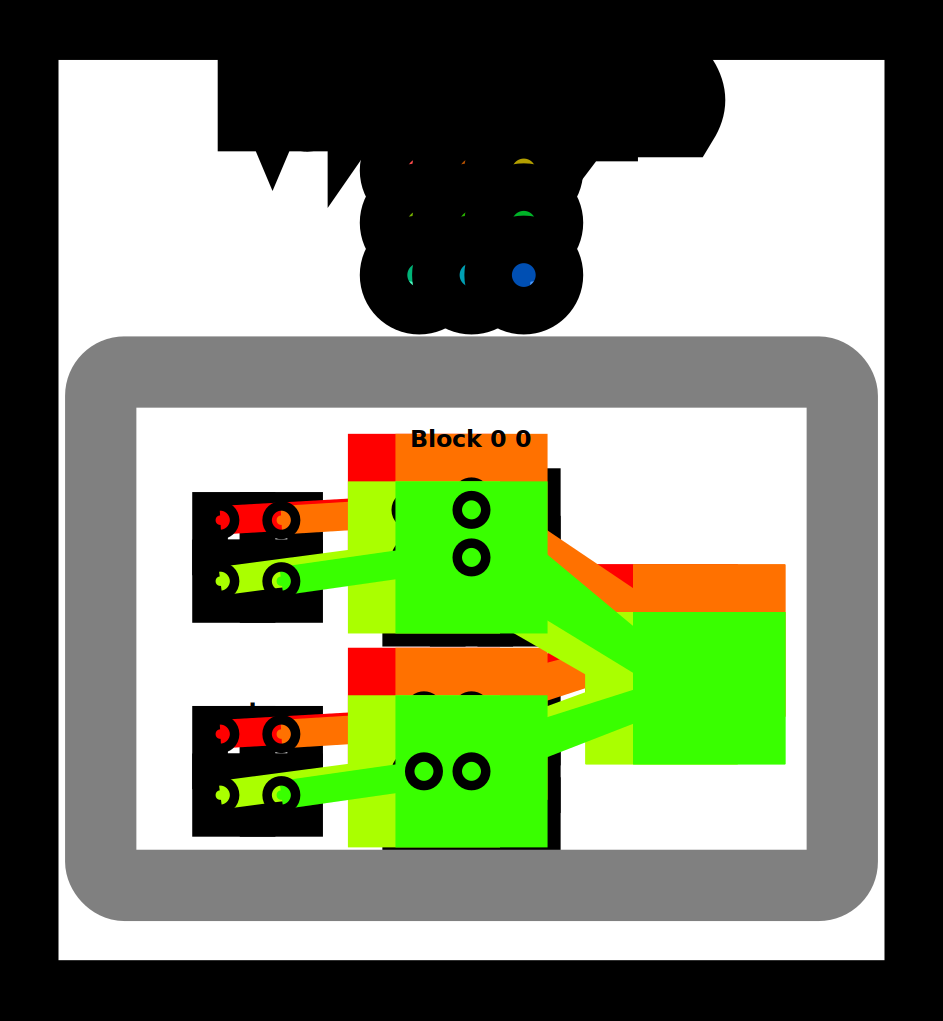

In [134]:
def matmul_spec(a, b):
    return a @ b


TPB = 3
def mm_oneblock_test(cuda):
    def call(out, a, b, size: int) -> None:
        a_shared = cuda.shared.array((TPB, TPB), numba.float32)
        b_shared = cuda.shared.array((TPB, TPB), numba.float32)

        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y

        # My comment: for each output position, we need to accumulate
        # over the whole row and whole column, so accumulated value is
        # defined here and then we iteratively go over blocks of size
        # `TPB x TPB` until we cover the full row and column.
        acc = 0
        for k in range(0, size, TPB):
            # My comment: use guards to make sure we pull only
            # from valid positions
            if i < size and k + local_j < size:
                a_shared[local_i, local_j] = a[i, k + local_j]
            if k + local_i < size and j < size:
                b_shared[local_i, local_j] = b[k + local_i, j]

            # My comment: sync threads after pulling is over
            cuda.syncthreads()

            # My comment: each thread goes over its respective row and
            # column of the shared memory
            for local_k in range(min(TPB, size - k)):
                acc += a_shared[local_i, local_k] * b_shared[local_k, local_j]

        # My comment: finally, write out the final output
        if i < size and j < size:
            out[i, j] = acc

    return call

# Test 1

SIZE = 2
out = np.zeros((SIZE, SIZE))
inp1 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
inp2 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE)).T

problem = CudaProblem(
    "Matmul (Simple)",
    mm_oneblock_test,
    [inp1, inp2],
    out,
    [SIZE],
    Coord(1, 1),
    Coord(TPB, TPB),
    spec=matmul_spec,
)
problem.check()
problem.show(sparse=False)

Passed Tests!
# Matmul (Full)
 
   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             6 |             1 |            16 |             6 | 



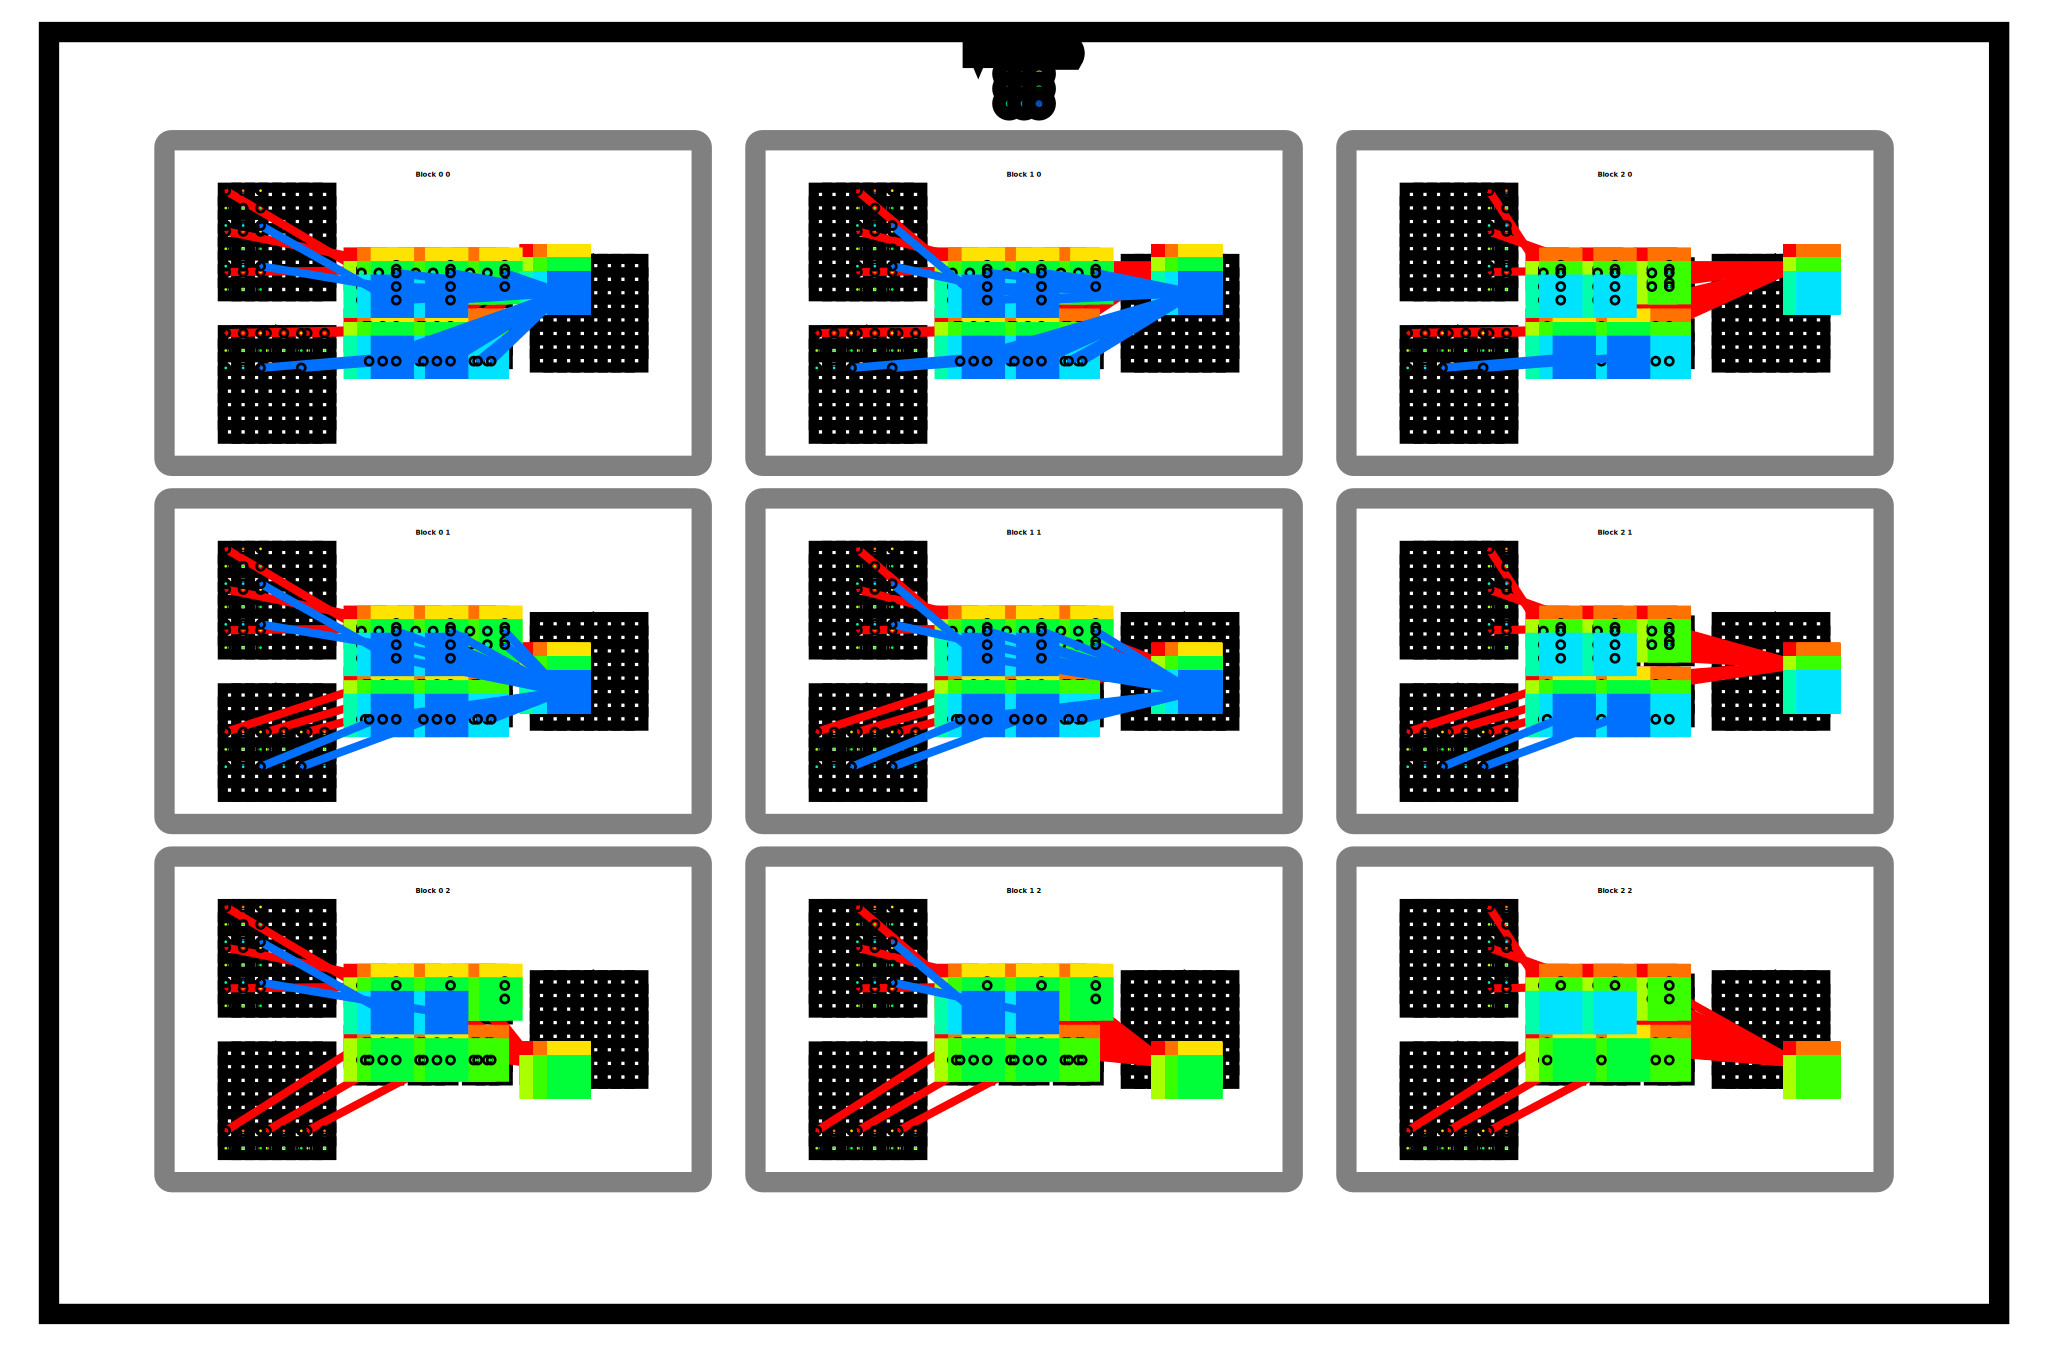

In [135]:
SIZE = 8
out = np.zeros((SIZE, SIZE))
inp1 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
inp2 = np.arange(SIZE * SIZE).reshape((SIZE, SIZE)).T

problem = CudaProblem(
    "Matmul (Full)",
    mm_oneblock_test,
    [inp1, inp2],
    out,
    [SIZE],
    Coord(3, 3),
    Coord(TPB, TPB),
    spec=matmul_spec,
)
problem.check()
problem.show(sparse=True)